# All Variables Modelling

All variables are used to predict the Absorbance. 3 different models are used:
* linear regression
* random forest
* neural network

In [1]:
import os
import inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

import statsmodels.api as sm

from quantile_forest import RandomForestQuantileRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Define paths

In [2]:
data_folder = os.path.join('..', 'data')

raw_data_folder = os.path.join(data_folder, 'raw_data')

# Load dataset

In [3]:
full_df = pd.read_excel(os.path.join(raw_data_folder, 'raw_full_dataset.xlsx'))

In [4]:
full_df

DateTime  nitrate    pH  turbidity  Ammonium  dissolvedoxygen  \
0    2012-08-29     5.54  8.31       3.42      0.01             4.71   
1    2012-08-30     5.56  8.29       3.10      0.02             4.75   
2    2012-08-31     5.51  8.31       3.60      0.04             5.08   
3    2012-09-01     5.49  8.40       4.00      0.06             5.68   
4    2012-09-02     5.39  8.43       3.97      0.15             5.98   
...         ...      ...   ...        ...       ...              ...   
4045 2023-09-26     7.56  8.30       3.96      0.03             5.46   
4046 2023-09-27     7.28  8.29       4.16      0.02             5.33   
4047 2023-09-28     7.34  8.27       3.80      0.02             5.23   
4048 2023-09-29     7.64  8.25       3.89      0.03             5.17   
4049 2023-09-30     8.14  8.23       3.93      0.02             5.12   

      watertemperature  Conductivity  redoxpotential  ABS254  \
0                28.10       1144.98          220.47    9.07   
1                27.57       1205.67          225.81   15.13   
2                26.37       1237.20          229.83   15.95   
3                25.04       1254.15          231.82     NaN   
4                24.75       1244.10          234.80   15.10   
...                ...           ...             ...     ...   
4045             25.95       1628.49          227.69    3.97   
4046             26.37       1610.67          227.02    3.81   
4047             26.60       1602.33          228.25    3.76   
4048             26.73       1613.81          230.54    4.18   
4049             26.74       1623.03          232.39    4.11   

      cumulated_rainfall_24h  flowriver  environmental_temperature  
0                        0.0     100.82                      27.02  
1                        0.4      97.40                      22.49  
2                        0.0      95.59                      21.03  
3                        0.0      94.97                      17.81  
4                        0.0      95.48                      19.43  
...                      ...        ...                        ...  
4045                     0.0      83.50                      20.50  
4046                     0.0      81.17                      21.76  
4047                     0.0      81.42                      22.17  
4048                     0.0      80.71                      22.03  
4049                     0.0      81.00                      22.28  

[4050 rows x 13 columns]

In [5]:
full_df.rename(
    columns={
        "flowriver": "Flow River",
        "cumulated_rainfall_24h": "Daily Cumulated Rainfall",
        "environmental_temperature": "Air Temperature",
        'nitrate': 'Nitrate',
        'dissolvedoxygen': 'Dissolved Oxygen',
        'turbidity': 'Turbidity',
        'watertemperature': 'Water Temperature',
        'redoxpotential': 'Redox Potential',
        'ABS254': 'Absorbance 254nm',
    },
    inplace=True,
)

In [6]:
full_df.isna().sum()

DateTime                      0
Nitrate                     176
pH                           99
Turbidity                   218
Ammonium                    413
Dissolved Oxygen            325
Water Temperature            86
Conductivity                141
Redox Potential             273
Absorbance 254nm            551
Daily Cumulated Rainfall     10
Flow River                   46
Air Temperature               1
dtype: int64

In [7]:
full_df = full_df.dropna()

# Multicollinearity Test

In [8]:
X = full_df[full_df.columns.difference(['DateTime'])]


vif_test = pd.DataFrame()
vif_test['variable'] = X.columns
vif_test['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [9]:
vif_test

variable         VIF
0           Absorbance 254nm    6.540941
1            Air Temperature   47.176356
2                   Ammonium    3.173699
3               Conductivity   25.978670
4   Daily Cumulated Rainfall    1.069393
5           Dissolved Oxygen   48.783197
6                 Flow River    7.219115
7                    Nitrate   40.705111
8            Redox Potential  135.308202
9                  Turbidity    3.208829
10         Water Temperature  135.962774
11                        pH  315.048971

In [10]:
full_df['Year'] = full_df['DateTime'].dt.year
full_df['Month'] = full_df['DateTime'].dt.month
full_df['Season'] = full_df['Month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else 'Spring' if x in [3, 4, 5] else 'Summer' if x in [6, 7, 8] else 'Autumn')

# convert Season to integer
full_df['Season'] = full_df['Season'].apply(lambda x: 1 if x == 'Winter' else 2 if x == 'Spring' else 3 if x == 'Summer' else 4)

full_df['Timestamp'] = full_df['DateTime'].apply(lambda x: x.timestamp())

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_26708/2418035427.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['Year'] = full_df['DateTime'].dt.year
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_26708/2418035427.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['Month'] = full_df['DateTime'].dt.month
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_26708/2418035427.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [11]:
X = full_df[full_df.columns.difference(['DateTime'])]


vif_test = pd.DataFrame()
vif_test['variable'] = X.columns
vif_test['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [12]:
vif_test

variable          VIF
0           Absorbance 254nm     2.848004
1            Air Temperature     9.194284
2                   Ammonium     1.120169
3               Conductivity     2.567642
4   Daily Cumulated Rainfall     1.035261
5           Dissolved Oxygen     2.397270
6                 Flow River     4.035563
7                      Month     2.229043
8                    Nitrate     1.914706
9            Redox Potential     1.271387
10                    Season     3.075324
11                 Timestamp   533.448374
12                 Turbidity     2.550653
13         Water Temperature    17.369615
14                      Year  7747.420938
15                        pH     1.354500

# Linear Regression

## All Features + Year

In [13]:
setting = 'All Features + Year'

### Split Data

In [14]:
X = full_df[full_df.columns.difference(['Absorbance 254nm', 'Season', 'Month', 'Timestamp'])]

y = full_df[['DateTime','Absorbance 254nm']]

In [15]:
# split data such that 2022 and 2023 are test data
X_train = X[X['DateTime'] < '2022-01-01']
X_test = X[X['DateTime'] >= '2022-01-01']

y_train = y[y['DateTime'] < '2022-01-01']
y_test = y[y['DateTime'] >= '2022-01-01']

In [16]:
X_train_fit = X_train[X_train.columns.difference(['DateTime'])]
X_test_fit = X_test[X_test.columns.difference(['DateTime'])]

y_train_fit = y_train[y_train.columns.difference(['DateTime'])]
y_test_fit = y_test[y_test.columns.difference(['DateTime'])]

In [17]:
scaler = StandardScaler()

X_train_fit = scaler.fit_transform(X_train_fit)
X_test_fit = scaler.transform(X_test_fit)

X_train_fit = pd.DataFrame(X_train_fit, columns=X_train.columns.difference(['DateTime']))
X_test_fit = pd.DataFrame(X_test_fit, columns=X_test.columns.difference(['DateTime']))

### With available future projections

#### Train Model

In [18]:
model = sm.OLS(y_train_fit.values, sm.add_constant(X_train_fit)).fit()

In [19]:
results = model.summary2()

#### Results

In [20]:
print(results)

                     Results: Ordinary least squares
Model:                OLS                Adj. R-squared:       0.599     
Dependent Variable:   y                  AIC:                  12603.3425
Date:                 2024-03-14 22:12   BIC:                  12677.1607
No. Observations:     2161               Log-Likelihood:       -6288.7   
Df Model:             12                 F-statistic:          269.9     
Df Residuals:         2148               Prob (F-statistic):   0.00      
R-squared:            0.601              Scale:                19.852    
-------------------------------------------------------------------------
                          Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------------
const                    12.4422   0.0958 129.8138 0.0000 12.2542 12.6301
Air Temperature          -0.1263   0.2681  -0.4712 0.6376 -0.6520  0.3994
Ammonium                  0.5131   0.1000   5.1289 0.0000  

In [21]:
print(results)

                     Results: Ordinary least squares
Model:                OLS                Adj. R-squared:       0.599     
Dependent Variable:   y                  AIC:                  12603.3425
Date:                 2024-03-14 22:12   BIC:                  12677.1607
No. Observations:     2161               Log-Likelihood:       -6288.7   
Df Model:             12                 F-statistic:          269.9     
Df Residuals:         2148               Prob (F-statistic):   0.00      
R-squared:            0.601              Scale:                19.852    
-------------------------------------------------------------------------
                          Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------------
const                    12.4422   0.0958 129.8138 0.0000 12.2542 12.6301
Air Temperature          -0.1263   0.2681  -0.4712 0.6376 -0.6520  0.3994
Ammonium                  0.5131   0.1000   5.1289 0.0000  

#### Predictions

In [22]:
# predict the model
predictions = model.get_prediction(sm.add_constant(X_test_fit)).summary_frame(alpha=0.05)

In [23]:
train_res = model.resid

In [24]:
print(results)

                     Results: Ordinary least squares
Model:                OLS                Adj. R-squared:       0.599     
Dependent Variable:   y                  AIC:                  12603.3425
Date:                 2024-03-14 22:12   BIC:                  12677.1607
No. Observations:     2161               Log-Likelihood:       -6288.7   
Df Model:             12                 F-statistic:          269.9     
Df Residuals:         2148               Prob (F-statistic):   0.00      
R-squared:            0.601              Scale:                19.852    
-------------------------------------------------------------------------
                          Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------------
const                    12.4422   0.0958 129.8138 0.0000 12.2542 12.6301
Air Temperature          -0.1263   0.2681  -0.4712 0.6376 -0.6520  0.3994
Ammonium                  0.5131   0.1000   5.1289 0.0000  

#### Plots

In [25]:
rmse = np.sqrt(mean_squared_error(y_test_fit, predictions['mean']))
r2 = r2_score(y_test_fit, predictions['mean'])

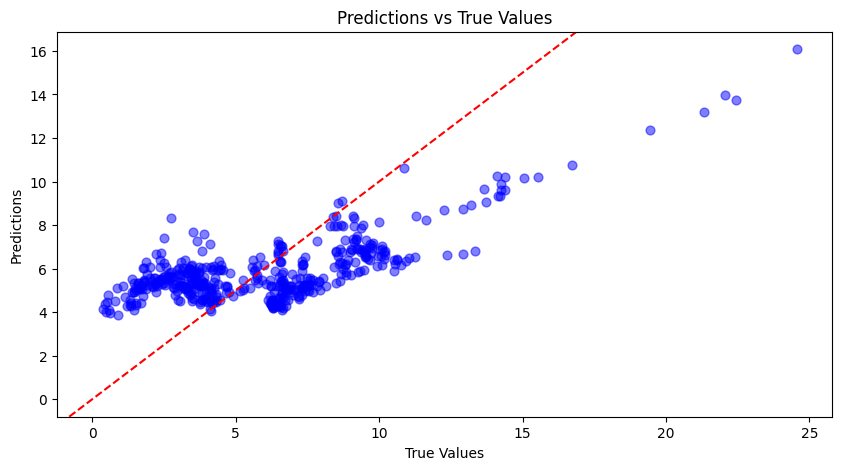

In [26]:
# plot the true vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test_fit, predictions['mean'], c='b', s=40, alpha=0.5)
plt.axline([0, 0], [1, 1], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'Predictions vs True Values')
plt.show()

In [27]:
residuals = y_test_fit['Absorbance 254nm'].values - predictions['mean'].values

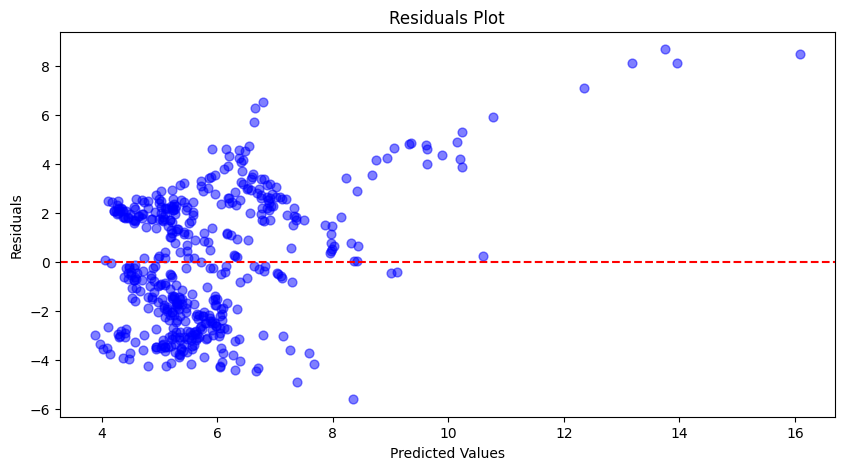

In [28]:
# plot the residuals 
plt.figure(figsize=(10, 5))
plt.scatter(predictions['mean'], residuals, c='b', s=40, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

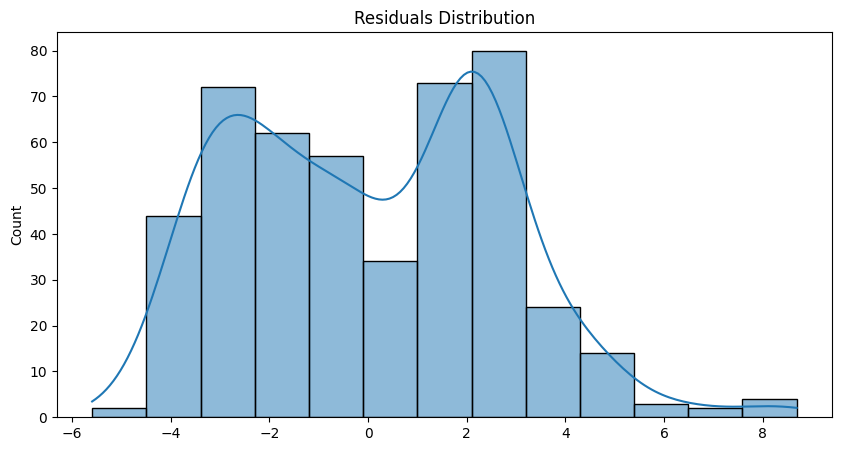

In [29]:
# plot the distribution of the residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.show()

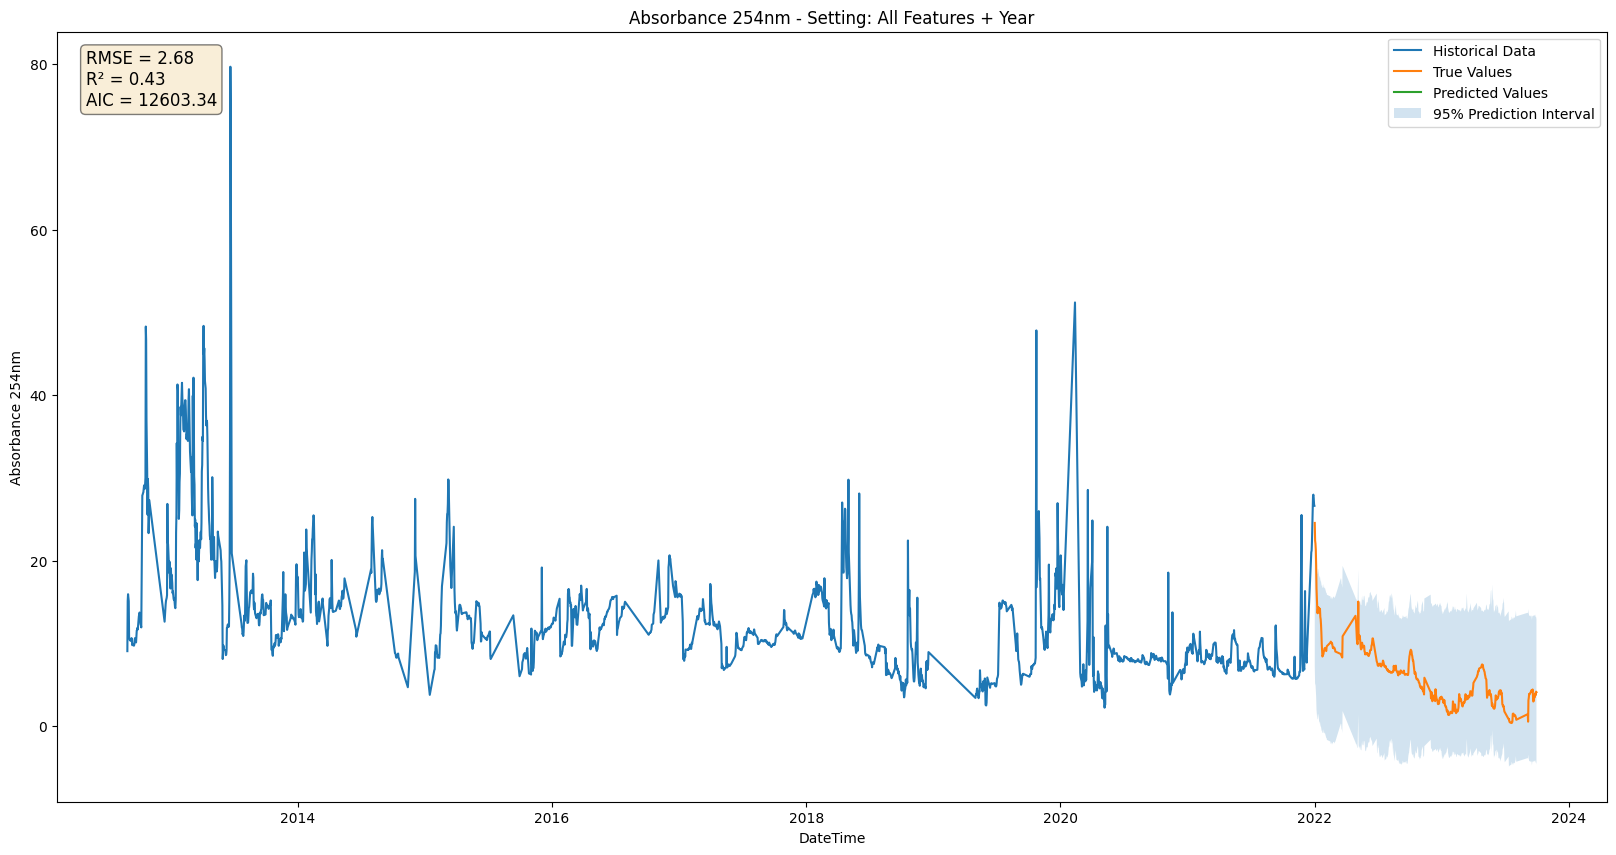

In [30]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=y_train['DateTime'], y=y_train['Absorbance 254nm'], label='Historical Data')
# sns.lineplot(x=y_train['DateTime'], y=model.fittedvalues.values, label='Fitted Values')
sns.lineplot(x=y_test['DateTime'], y=y_test['Absorbance 254nm'], label='True Values')
sns.lineplot(x=y_test['DateTime'], y=predictions['mean'], label='Predicted Values')
plt.fill_between(y_test['DateTime'], predictions['obs_ci_lower'], predictions['obs_ci_upper'], alpha=0.2, label='95% Prediction Interval')
plt.xlabel('DateTime')
plt.ylabel('Absorbance 254nm')

# add rmse and r2 to the plot in a box
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

text_string = '\n'.join((
    f'RMSE = {rmse:.2f}',
    f'R\u00b2 = {r2:.2f}',
    f'AIC = {model.aic:.2f}',
))

plt.text(y_train['DateTime'].iloc[0] - pd.Timedelta(days=120), 75, s=text_string, fontsize=12, bbox=props)

plt.title(f'Absorbance 254nm - Setting: {setting}')

plt.legend()
plt.show()

#### Store Results

In [31]:
lr_pred = predictions['mean']
lr_lower_bound = predictions['obs_ci_lower']
lr_upper_bound = predictions['obs_ci_upper']
lr_rmse = rmse
lr_r2 = r2

### Backward Feature Selection

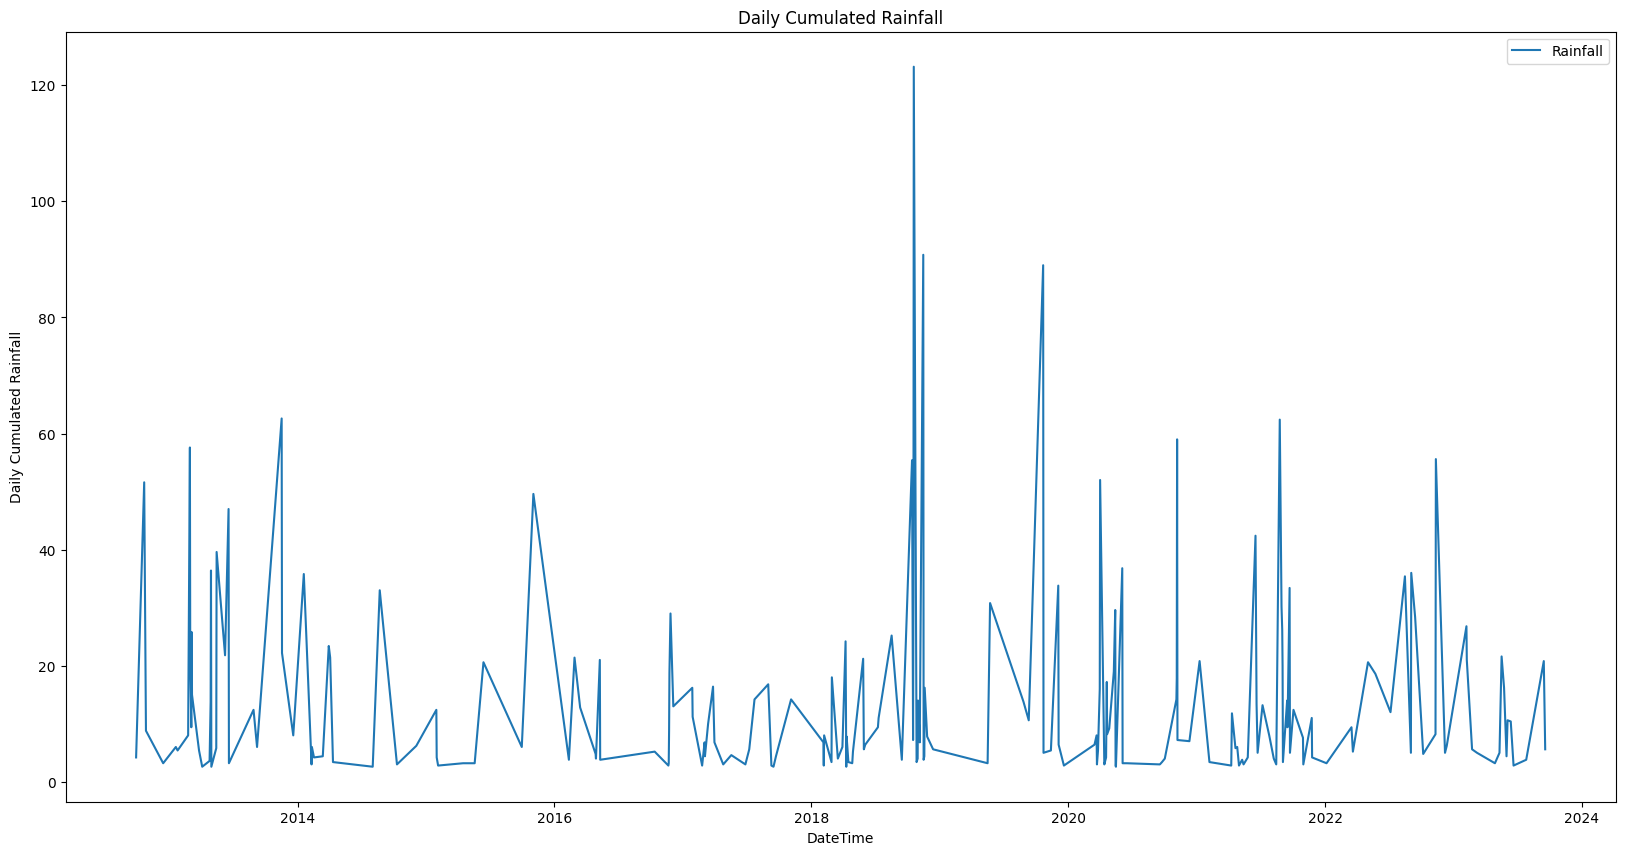

In [184]:
from sklearn.preprocessing import MinMaxScaler


plt.figure(figsize=(20, 10))

scaled_rainfall = scaler.fit_transform(X['Daily Cumulated Rainfall'].values.reshape(-1, 1))
# get only > 0 rainfall
scaled_rainfall  = pd.DataFrame(X['Daily Cumulated Rainfall'], columns=['Daily Cumulated Rainfall'])
scaled_rainfall['DateTime'] = X['DateTime']
scaled_rainfall = scaled_rainfall[scaled_rainfall['Daily Cumulated Rainfall'] > 2.5]

# scale min-max
# scaler = MinMaxScaler()

# scaled_rainfall['Daily Cumulated Rainfall'] = scaler.fit_transform(scaled_rainfall['Daily Cumulated Rainfall'].values.reshape(-1, 1))


sns.lineplot(x=scaled_rainfall['DateTime'], y=scaled_rainfall['Daily Cumulated Rainfall'], label='Rainfall')

plt.xlabel('DateTime')
plt.ylabel('Daily Cumulated Rainfall')

plt.title(f'Daily Cumulated Rainfall')

plt.legend()
plt.show()

In [185]:
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose

In [186]:
scaled_rainfall.set_index('DateTime', inplace=True)

In [187]:
result = seasonal_decompose(scaled_rainfall, model='additive', extrapolate_trend='freq', period=30)
trend = result.trend

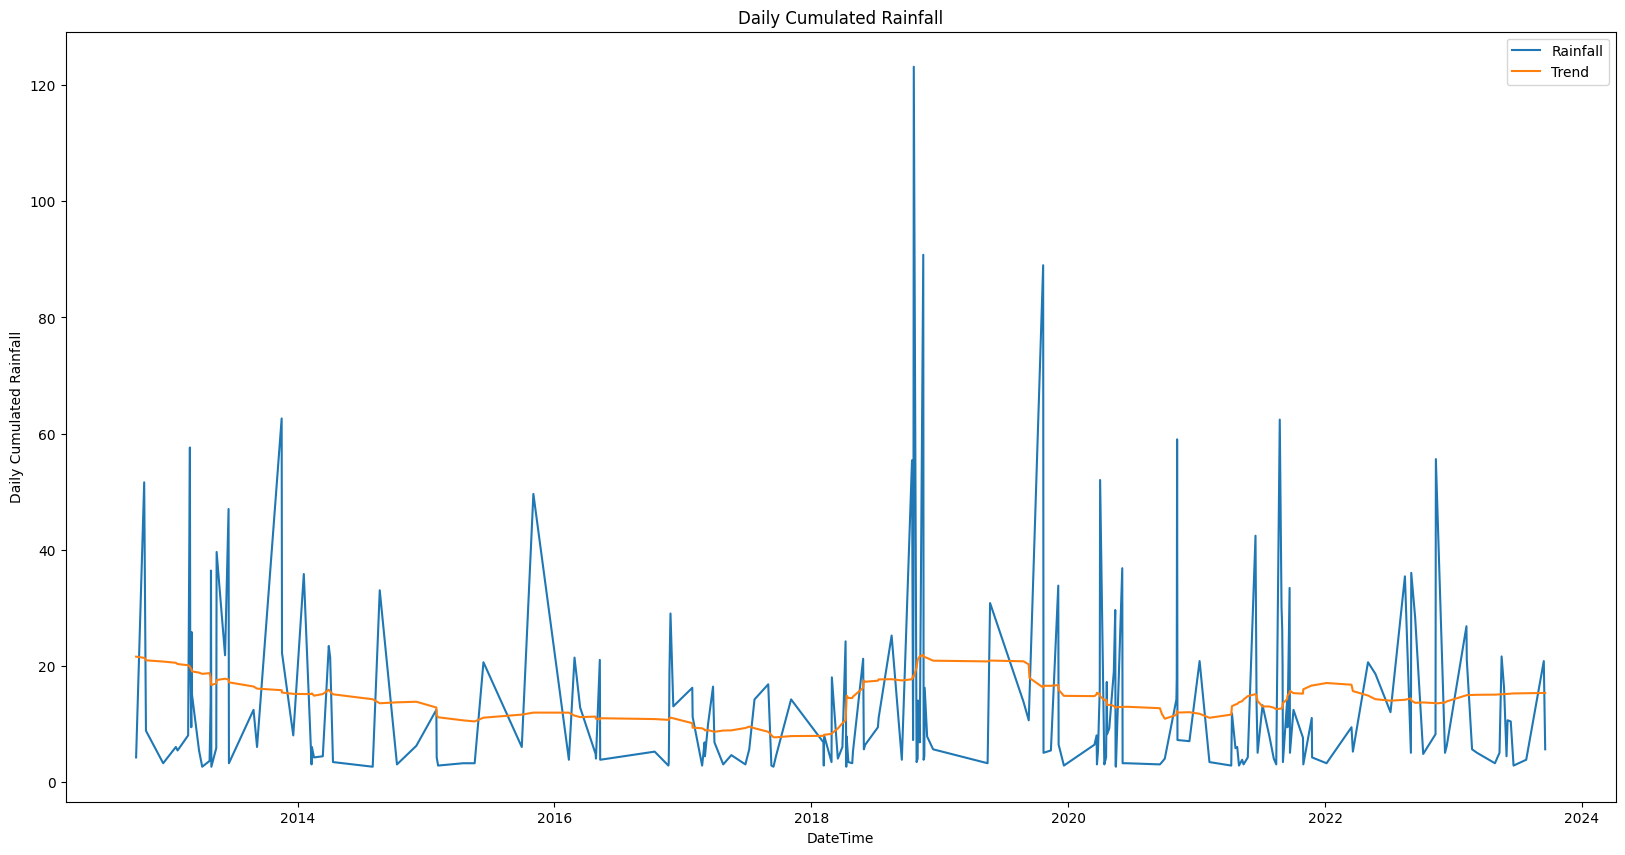

In [188]:
plt.figure(figsize=(20, 10))

sns.lineplot(x=scaled_rainfall.index, y=scaled_rainfall['Daily Cumulated Rainfall'], label='Rainfall')
sns.lineplot(x=scaled_rainfall.index, y=trend.values, label='Trend')

plt.xlabel('DateTime')
plt.ylabel('Daily Cumulated Rainfall')

plt.title(f'Daily Cumulated Rainfall')


plt.legend()
plt.show()

In [159]:
# rainy days per year
rain_df = pd.DataFrame()

for year in scaled_rainfall.index.year.unique():
    rain_df.loc[year, 'Rainy Days > 0 mm'] = scaled_rainfall[scaled_rainfall.index.year == year].shape[0]

In [177]:
rain_df.to_excel('Rainy Days.xlsx')

In [173]:
for year in scaled_rainfall.index.year.unique():
    rain_df.loc[year, 'Tot Days'] = scaled_rainfall[scaled_rainfall.index.year == year].shape[0]

In [176]:
# compute % of rainy days
rain_df['% Rainy Days > 0 mm'] = rain_df['Rainy Days > 0 mm'] / rain_df['Tot Days'] * 100
rain_df['% Rainy Days > 2.5 mm'] = rain_df['Rainy Days > 2.5 mm'] / rain_df['Tot Days'] * 100

In [75]:
def backward_feature_selection(X_tr, y_tr, X_ts, y_ts, pvalue_threshold=0.05):
    
    # remove multicollinearity variables
    drop_columns = ['Air Temperature']
    
    X_tr = X_tr.drop(columns=drop_columns)
    X_ts = X_ts.drop(columns=drop_columns)
    
    initial_list = list(X_tr.columns)
    included = list(X_tr.columns)
    
    summaries = {}
    results = {}
    bfs_insights = {}
    index = 0
    excluded_variable = None
    
    changed = True
    
    while True:
        
        changed = False

        # Fit the regression model
        model = sm.OLS(y_tr.values, sm.add_constant(X_tr[included])).fit()
        result = {}
        
        # PREDICTION STEP
        predictions = model.get_prediction(sm.add_constant(X_ts[included])).summary_frame(alpha=0.05)
        
        train_res = model.resid

  
        rmse = np.sqrt(mean_squared_error(y_ts, predictions['mean']))
        r2 = r2_score(y_ts, predictions['mean'])

        residuals = y_ts['Absorbance 254nm'].values - predictions['mean'].values
        
        model.aic
        #### Store Results
        
        result["y_pred"] = predictions["mean"]
        result["y_lower_bound"] = predictions["obs_ci_lower"]
        result["y_upper_bound"] = predictions["obs_ci_upper"]
        
        result["train_res"] = train_res
        result["residuals"] = residuals
        
        result["rmse"] = rmse
        result["r2"] = r2
        result["aic"] = model.aic
        
        result["model"] = model
        
        results[index] = result
        
        # FEATURE SELECTION STEP
        index += 1

        # Get the pvalues of the model
        pvalues = model.pvalues
        
        insights = pd.DataFrame({'step': index,
                           'n_features': [len(included)] * len(initial_list),
                           'features': [included] * len(initial_list),
                           'dropped_feature': excluded_variable})
        
        bfs_insights[index] = insights
        summaries[index] = model.summary2()

        # Find the variable with the highest pvalue
        highest_pvalue = pvalues.max()
        if highest_pvalue >= pvalue_threshold:
            changed = True
            excluded_variable = pvalues.idxmax()
            included.remove(excluded_variable)

        if not changed:
            break
        
        

    return results, summaries, bfs_insights

In [76]:
results, summaries, bfs_insights = backward_feature_selection(X_train_fit, y_train_fit, X_test_fit, y_test_fit, pvalue_threshold=0.05)

#### Results

In [77]:
# show the insights and summaries of the backward feature selection
for i in summaries.keys():
    step = bfs_insights[i]['step'].iloc[0]
    print(f"================= Step {step} =================")
    print()
    print(f"N Features: {bfs_insights[step]['n_features'].iloc[0]}")
    print(f"Features: {bfs_insights[step]['features'].iloc[0]}")
    print(f"Dropped Feature: {bfs_insights[step]['dropped_feature'].iloc[0]}")
        
    print()
    print(summaries[i])
    print("\n")

================= Step 1 =================

N Features: 11
Features: ['Ammonium', 'Flow River', 'Redox Potential', 'Turbidity', 'Water Temperature', 'Year']
Dropped Feature: None

                     Results: Ordinary least squares
Model:                OLS                Adj. R-squared:       0.599     
Dependent Variable:   y                  AIC:                  12601.5658
Date:                 2024-03-14 22:53   BIC:                  12669.7057
No. Observations:     2161               Log-Likelihood:       -6288.8   
Df Model:             11                 F-statistic:          294.5     
Df Residuals:         2149               Prob (F-statistic):   0.00      
R-squared:            0.601              Scale:                19.845    
-------------------------------------------------------------------------
                          Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------------
const                    12

#### Plots

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_fit, predictions['mean']))
r2 = r2_score(y_test_fit, predictions['mean'])

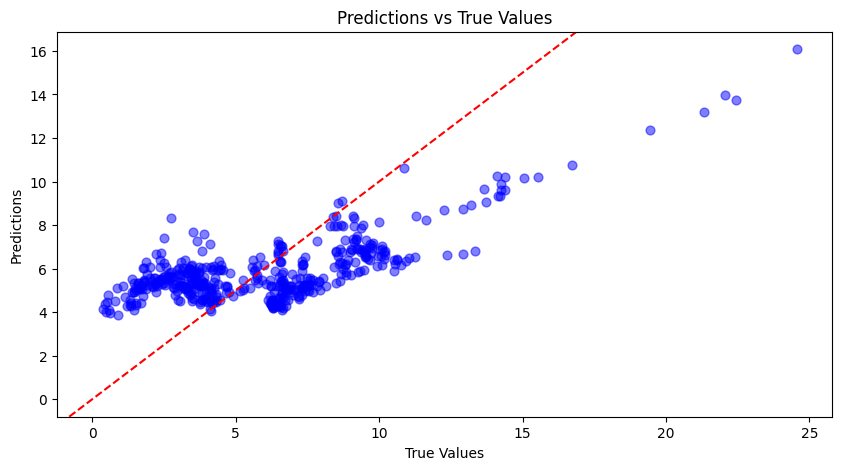

In [ ]:
# plot the true vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test_fit, predictions['mean'], c='b', s=40, alpha=0.5)
plt.axline([0, 0], [1, 1], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'Predictions vs True Values')
plt.show()

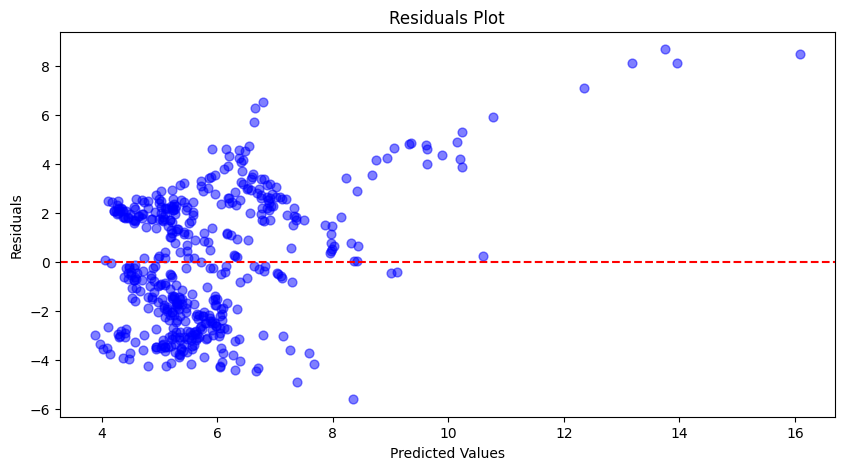

In [ ]:
# plot the residuals 
residuals = y_test_fit['Absorbance 254nm'] - predictions['mean']
plt.figure(figsize=(10, 5))
plt.scatter(predictions['mean'], residuals, c='b', s=40, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

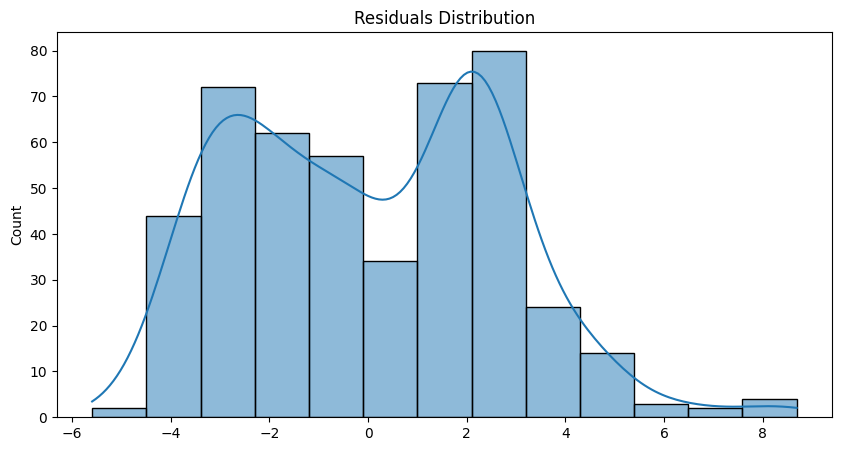

In [ ]:
# plot the distribution of the residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.show()

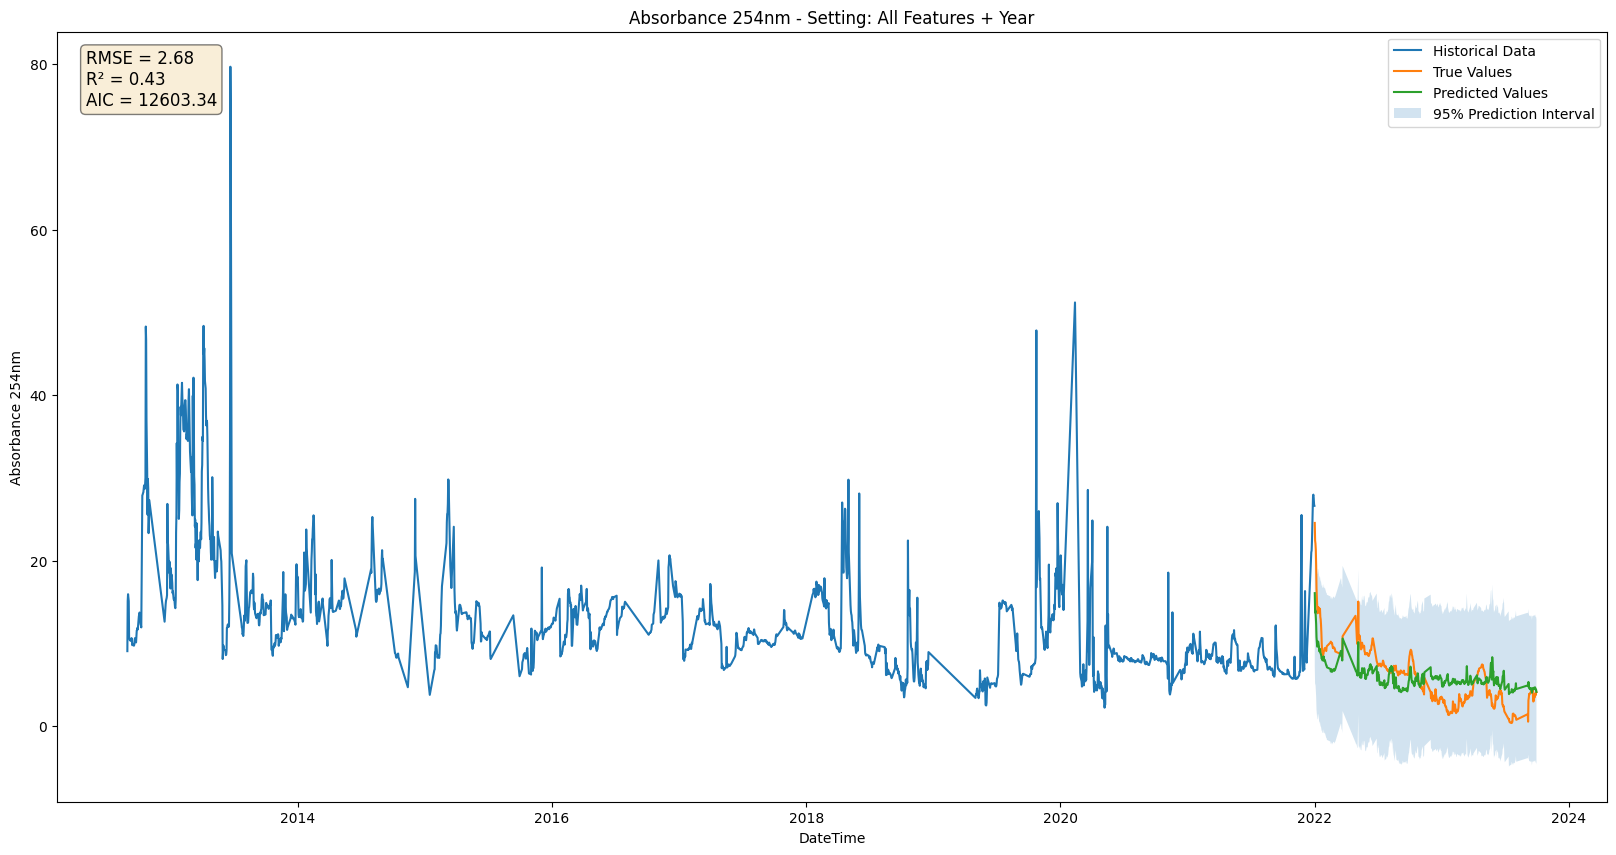

In [ ]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=y_train['DateTime'], y=y_train['Absorbance 254nm'], label='Historical Data')
# sns.lineplot(x=y_train['DateTime'], y=model.fittedvalues.values, label='Fitted Values')
sns.lineplot(x=y_test['DateTime'], y=y_test['Absorbance 254nm'], label='True Values')
sns.lineplot(x=y_test['DateTime'], y=predictions['mean'], label='Predicted Values')
plt.fill_between(y_test['DateTime'], predictions['obs_ci_lower'], predictions['obs_ci_upper'], alpha=0.2, label='95% Prediction Interval')
plt.xlabel('DateTime')
plt.ylabel('Absorbance 254nm')

# add rmse and r2 to the plot in a box
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

text_string = '\n'.join((
    f'RMSE = {rmse:.2f}',
    f'R\u00b2 = {r2:.2f}',
    f'AIC = {model.aic:.2f}',
))

plt.text(y_train['DateTime'].iloc[0] - pd.Timedelta(days=120), 75, s=text_string, fontsize=12, bbox=props)

plt.title(f'Absorbance 254nm - Setting: {setting}')

plt.legend()
plt.show()

#### Store Results

In [ ]:
lr_pred = predictions['mean']
lr_lower_bound = predictions['obs_ci_lower']
lr_upper_bound = predictions['obs_ci_upper']
lr_rmse = rmse
lr_r2 = r2

## Remove Features with p-value > 0.05

They are:

* Air Temperature
* Conductivity
* Daily Cumulated Rainfall
* Dissolved Oxygen
* Nitrate
* Water Temperature
* pH

In [32]:
setting = 'Ammonium + Flow River + Redox Potential + Turbidity + Year'

### Split Data

In [33]:
X = full_df[full_df.columns.difference(['Absorbance 254nm', 'Season', 'Month', 'Timestamp', 'Air Temperature', 'Daily Cumulated Rainfall', 'Nitrate', 'Dissolved Oxygen', 'Water Temperature', 'pH', 'Conductivity'])]

y = full_df[['DateTime','Absorbance 254nm']]

In [34]:
# split data such that 2022 and 2023 are test data
X_train = X[X['DateTime'] < '2022-01-01']
X_test = X[X['DateTime'] >= '2022-01-01']

y_train = y[y['DateTime'] < '2022-01-01']
y_test = y[y['DateTime'] >= '2022-01-01']

In [35]:
X_train_fit = X_train[X_train.columns.difference(['DateTime'])]
X_test_fit = X_test[X_test.columns.difference(['DateTime'])]

y_train_fit = y_train[y_train.columns.difference(['DateTime'])]
y_test_fit = y_test[y_test.columns.difference(['DateTime'])]

### Train Model

In [36]:
model = sm.OLS(y_train_fit, sm.add_constant(X_train_fit)).fit()

In [37]:
results = model.summary2()

### Results

In [38]:
print(results)

                   Results: Ordinary least squares
Model:               OLS               Adj. R-squared:      0.595     
Dependent Variable:  Absorbance 254nm  AIC:                 12619.1607
Date:                2024-03-14 01:57  BIC:                 12653.2307
No. Observations:    2161              Log-Likelihood:      -6303.6   
Df Model:            5                 F-statistic:         635.0     
Df Residuals:        2155              Prob (F-statistic):  0.00      
R-squared:           0.596             Scale:               20.062    
----------------------------------------------------------------------
                  Coef.   Std.Err.    t     P>|t|    [0.025    0.975] 
----------------------------------------------------------------------
const           2222.5016  73.6915  30.1595 0.0000 2077.9877 2367.0156
Ammonium          15.8245   2.9345   5.3926 0.0000   10.0698   21.5792
Flow River         0.0034   0.0004   8.2855 0.0000    0.0026    0.0042
Redox Potential   -0.0358 

### Predictions

In [39]:
# predict the model
predictions = model.get_prediction(sm.add_constant(X_test_fit)).summary_frame(alpha=0.05)

In [40]:
predictions

mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
3412  14.547489  0.384115      13.794214      15.300764      5.731412   
3413  12.252610  0.338098      11.589579      12.915642      3.443785   
3414  12.531600  0.315612      11.912665      13.150535      3.725984   
3415  11.885313  0.286655      11.323165      12.447462      3.083507   
3416  11.063857  0.267439      10.539391      11.588323      2.264376   
...         ...       ...            ...            ...           ...   
4045   5.130392  0.330665       4.481937       5.778848     -3.677348   
4046   5.026768  0.331550       4.376577       5.676959     -3.781100   
4047   4.914225  0.328095       4.270808       5.557641     -3.893146   
4048   5.005406  0.321938       4.374064       5.636749     -3.801090   
4049   4.789610  0.315373       4.171142       5.408078     -4.015973   

      obs_ci_upper  
3412     23.363566  
3413     21.061436  
3414     21.337216  
3415     20.687120  
3416     19.863337  
...            ...  
4045     13.938133  
4046     13.834636  
4047     13.721596  
4048     13.811903  
4049     13.595193  

[471 rows x 6 columns]

### Plots

In [41]:
rmse = np.sqrt(mean_squared_error(y_test_fit, predictions['mean']))
r2 = r2_score(y_test_fit, predictions['mean'])

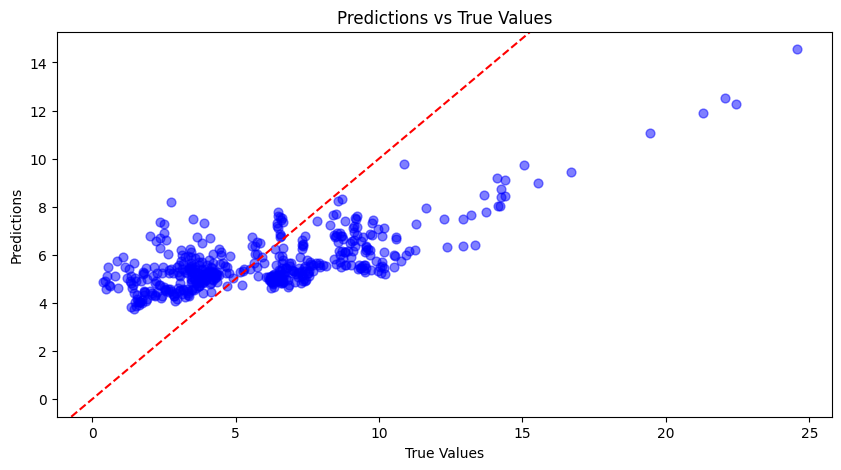

In [42]:
# plot the true vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test_fit, predictions['mean'], c='b', s=40, alpha=0.5)
plt.axline([0, 0], [1, 1], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'Predictions vs True Values')
plt.show()

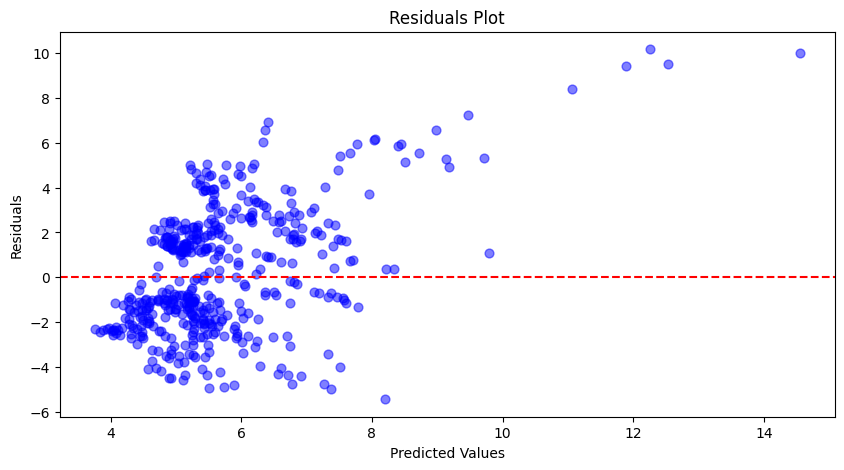

In [43]:
# plot the residuals 
residuals = y_test_fit['Absorbance 254nm'] - predictions['mean']
plt.figure(figsize=(10, 5))
plt.scatter(predictions['mean'], residuals, c='b', s=40, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

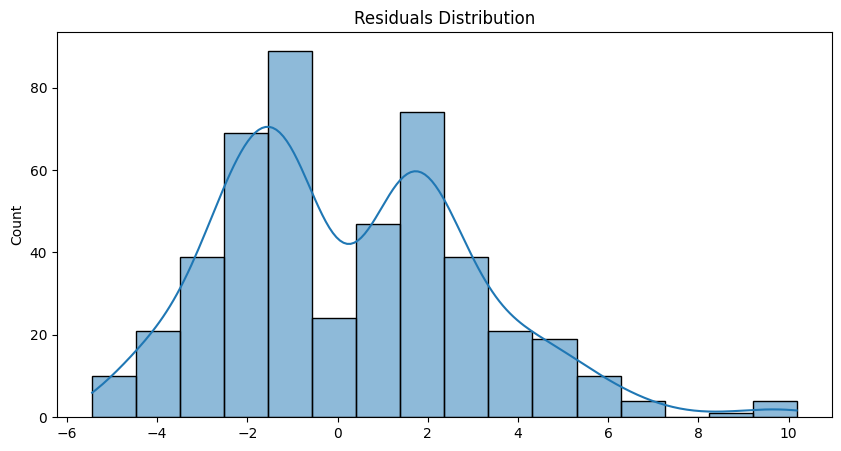

In [44]:
# plot the distribution of the residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.show()

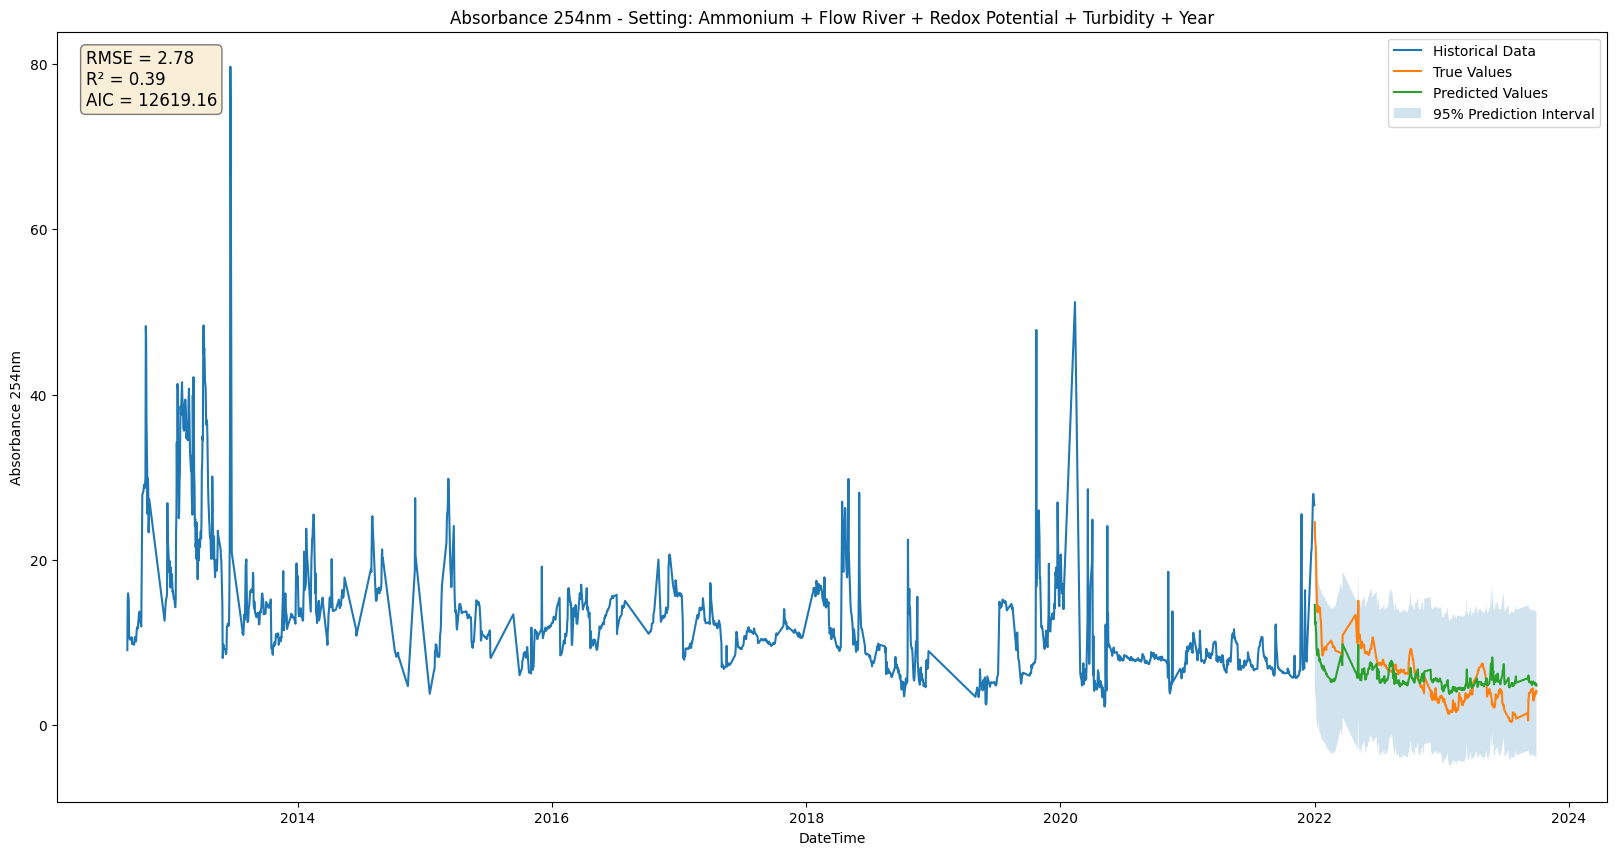

In [45]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=y_train['DateTime'], y=y_train['Absorbance 254nm'], label='Historical Data')
sns.lineplot(x=y_test['DateTime'], y=y_test['Absorbance 254nm'], label='True Values')
sns.lineplot(x=y_test['DateTime'], y=predictions['mean'], label='Predicted Values')
plt.fill_between(y_test['DateTime'], predictions['obs_ci_lower'], predictions['obs_ci_upper'], alpha=0.2, label='95% Prediction Interval')
plt.xlabel('DateTime')
plt.ylabel('Absorbance 254nm')

# add rmse and r2 to the plot in a box
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

text_string = '\n'.join((
    f'RMSE = {rmse:.2f}',
    f'R\u00b2 = {r2:.2f}',
    f'AIC = {model.aic:.2f}',
))

plt.text(y_train['DateTime'].iloc[0] - pd.Timedelta(days=120), 75, s=text_string, fontsize=12, bbox=props)

plt.title(f'Absorbance 254nm - Setting: {setting}')

plt.legend()
plt.show()

# Random Forest

In [46]:
setting = 'All Features + Year'

### Split Data

In [47]:
X = full_df[full_df.columns.difference(['Absorbance 254nm', 'Season', 'Month', 'Timestamp', 'Year'])]

y = full_df[['DateTime','Absorbance 254nm']]

In [48]:
# split data such that 2022 and 2023 are test data
X_train = X[X['DateTime'] < '2022-01-01']
X_test = X[X['DateTime'] >= '2022-01-01']

y_train = y[y['DateTime'] < '2022-01-01']
y_test = y[y['DateTime'] >= '2022-01-01']

In [49]:
X_train_fit = X_train[X_train.columns.difference(['DateTime'])]
X_test_fit = X_test[X_test.columns.difference(['DateTime'])]

y_train_fit = y_train[y_train.columns.difference(['DateTime'])]
y_test_fit = y_test[y_test.columns.difference(['DateTime'])]

In [143]:
scaler = StandardScaler()
# scale the data and keep the column names
X_train_fit = scaler.fit_transform(X_train_fit)
X_test_fit = scaler.transform(X_test_fit)

X_train_fit = pd.DataFrame(X_train_fit, columns=X_train.columns.difference(['DateTime']))
X_test_fit = pd.DataFrame(X_test_fit, columns=X_test.columns.difference(['DateTime']))

### Train Model

#### Perform Hyperparameter Tuning

In [140]:
import optuna

In [144]:
from sklearn import model_selection


def objective(trial):

    n_estimators = trial.suggest_int("n_estimators", 5, 100, 5)
    max_depth = trial.suggest_int("max_depth", 5, 20, 1)
    max_features = trial.suggest_int(
        "max_features", 1, X_train_fit.shape[1], 1
    )
    criterion = trial.suggest_categorical("criterion", ["squared_error", "absolute_error", "friedman_mse", "poisson"])
    model = RandomForestQuantileRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        criterion=criterion,
        random_state=42,
    )

    cv = model_selection.KFold(n_splits=5)
    results = model_selection.cross_val_score(
        estimator=model, X=X_train_fit, y=y_train_fit.values, cv=cv, scoring="neg_mean_squared_error",
    )
    return results.mean()

In [145]:
study = optuna.create_study(
    direction="maximize",
    storage="sqlite:///RandomForest.sqlite3",
    study_name="Hyperparameter Tuning - All Features + Year",
    load_if_exists=True,
)
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2024-03-14 17:14:17,759] Using an existing study with name 'Hyperparameter Tuning - All Features + Year' instead of creating a new one.


  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/209021125.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 5, 100, 5)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/209021125.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int("max_depth", 5, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/209021125.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_features = trial.suggest_int(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change 

[I 2024-03-14 17:14:20,214] Trial 3 finished with value: -36.10090359753229 and parameters: {'n_estimators': 10, 'max_depth': 19, 'max_features': 5, 'criterion': 'absolute_error'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:14:22,578] Trial 4 finished with value: -39.34308404838658 and parameters: {'n_estimators': 70, 'max_depth': 20, 'max_features': 5, 'criterion': 'friedman_mse'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:14:36,895] Trial 5 finished with value: -38.84541332178598 and parameters: {'n_estimators': 55, 'max_depth': 17, 'max_features': 6, 'criterion': 'absolute_error'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:14:48,342] Trial 6 finished with value: -37.193148924813954 and parameters: {'n_estimators': 75, 'max_depth': 5, 'max_features': 5, 'criterion': 'absolute_error'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:14:54,506] Trial 7 finished with value: -39.93127533808057 and parameters: {'n_estimators': 25, 'max_depth': 6, 'max_features': 8, 'criterion': 'absolute_error'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:14:57,361] Trial 8 finished with value: -39.81196098761868 and parameters: {'n_estimators': 75, 'max_depth': 16, 'max_features': 6, 'criterion': 'poisson'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:14:59,562] Trial 9 finished with value: -40.03065232486528 and parameters: {'n_estimators': 45, 'max_depth': 17, 'max_features': 9, 'criterion': 'poisson'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:15:05,641] Trial 10 finished with value: -37.46087681100847 and parameters: {'n_estimators': 80, 'max_depth': 17, 'max_features': 1, 'criterion': 'absolute_error'}. Best is trial 3 with value: -36.10090359753229.
[I 2024-03-14 17:15:05,748] Trial 11 finished with value: -43.2488609769267 and parameters: {'n_estimators': 5, 'max_depth': 12, 'max_features': 1, 'criterion': 'squared_error'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:15:09,462] Trial 12 finished with value: -37.08255786924771 and parameters: {'n_estimators': 100, 'max_depth': 10, 'max_features': 12, 'criterion': 'friedman_mse'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:15:13,404] Trial 13 finished with value: -37.22071940659481 and parameters: {'n_estimators': 95, 'max_depth': 11, 'max_features': 12, 'criterion': 'squared_error'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:15:14,066] Trial 14 finished with value: -36.84966344912753 and parameters: {'n_estimators': 45, 'max_depth': 9, 'max_features': 3, 'criterion': 'friedman_mse'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:15:20,496] Trial 15 finished with value: -37.95644789560346 and parameters: {'n_estimators': 45, 'max_depth': 14, 'max_features': 3, 'criterion': 'absolute_error'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:15:20,980] Trial 16 finished with value: -36.891148488794805 and parameters: {'n_estimators': 25, 'max_depth': 9, 'max_features': 4, 'criterion': 'friedman_mse'}. Best is trial 3 with value: -36.10090359753229.
[I 2024-03-14 17:15:21,130] Trial 17 finished with value: -46.595992817765804 and parameters: {'n_estimators': 5, 'max_depth': 13, 'max_features': 3, 'criterion': 'poisson'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:15:21,876] Trial 18 finished with value: -36.34547307060453 and parameters: {'n_estimators': 60, 'max_depth': 8, 'max_features': 3, 'criterion': 'squared_error'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:15:24,483] Trial 19 finished with value: -38.24608779918849 and parameters: {'n_estimators': 60, 'max_depth': 20, 'max_features': 8, 'criterion': 'squared_error'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:15:25,237] Trial 20 finished with value: -37.32790426096997 and parameters: {'n_estimators': 35, 'max_depth': 15, 'max_features': 2, 'criterion': 'squared_error'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:15:26,561] Trial 21 finished with value: -39.0217937936233 and parameters: {'n_estimators': 65, 'max_depth': 8, 'max_features': 7, 'criterion': 'squared_error'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:15:27,225] Trial 22 finished with value: -38.87391922755752 and parameters: {'n_estimators': 40, 'max_depth': 9, 'max_features': 4, 'criterion': 'squared_error'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:15:29,350] Trial 23 finished with value: -37.84154885627833 and parameters: {'n_estimators': 15, 'max_depth': 11, 'max_features': 3, 'criterion': 'absolute_error'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:15:30,000] Trial 24 finished with value: -36.31000232537315 and parameters: {'n_estimators': 50, 'max_depth': 7, 'max_features': 4, 'criterion': 'friedman_mse'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:15:30,825] Trial 25 finished with value: -37.07843397260714 and parameters: {'n_estimators': 55, 'max_depth': 7, 'max_features': 5, 'criterion': 'squared_error'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:15:35,269] Trial 26 finished with value: -40.55965159396116 and parameters: {'n_estimators': 35, 'max_depth': 5, 'max_features': 4, 'criterion': 'absolute_error'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:15:35,881] Trial 27 finished with value: -36.16195552754256 and parameters: {'n_estimators': 65, 'max_depth': 7, 'max_features': 2, 'criterion': 'friedman_mse'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:15:36,601] Trial 28 finished with value: -36.30782097166089 and parameters: {'n_estimators': 90, 'max_depth': 6, 'max_features': 2, 'criterion': 'friedman_mse'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:15:37,233] Trial 29 finished with value: -36.95008289009708 and parameters: {'n_estimators': 90, 'max_depth': 5, 'max_features': 2, 'criterion': 'friedman_mse'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:15:37,923] Trial 30 finished with value: -36.226837478295266 and parameters: {'n_estimators': 85, 'max_depth': 6, 'max_features': 2, 'criterion': 'friedman_mse'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:15:39,154] Trial 31 finished with value: -36.608542691600384 and parameters: {'n_estimators': 85, 'max_depth': 13, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:15:39,827] Trial 32 finished with value: -36.226837478295266 and parameters: {'n_estimators': 85, 'max_depth': 6, 'max_features': 2, 'criterion': 'friedman_mse'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:15:40,359] Trial 33 finished with value: -38.30384502258683 and parameters: {'n_estimators': 80, 'max_depth': 6, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:15:41,983] Trial 34 finished with value: -36.37516107387627 and parameters: {'n_estimators': 70, 'max_depth': 19, 'max_features': 2, 'criterion': 'friedman_mse'}. Best is trial 3 with value: -36.10090359753229.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:15:42,846] Trial 35 finished with value: -35.709394849029174 and parameters: {'n_estimators': 85, 'max_depth': 8, 'max_features': 2, 'criterion': 'friedman_mse'}. Best is trial 35 with value: -35.709394849029174.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:15:44,658] Trial 36 finished with value: -38.05343942821935 and parameters: {'n_estimators': 100, 'max_depth': 8, 'max_features': 6, 'criterion': 'friedman_mse'}. Best is trial 35 with value: -35.709394849029174.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:15:46,121] Trial 37 finished with value: -38.41976776794116 and parameters: {'n_estimators': 70, 'max_depth': 10, 'max_features': 5, 'criterion': 'friedman_mse'}. Best is trial 35 with value: -35.709394849029174.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:16:03,720] Trial 38 finished with value: -40.07350366735095 and parameters: {'n_estimators': 75, 'max_depth': 7, 'max_features': 7, 'criterion': 'absolute_error'}. Best is trial 35 with value: -35.709394849029174.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:16:07,189] Trial 39 finished with value: -39.23631940242494 and parameters: {'n_estimators': 65, 'max_depth': 19, 'max_features': 10, 'criterion': 'poisson'}. Best is trial 35 with value: -35.709394849029174.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:16:07,699] Trial 40 finished with value: -39.36242252525982 and parameters: {'n_estimators': 90, 'max_depth': 5, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 35 with value: -35.709394849029174.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:16:25,456] Trial 41 finished with value: -38.518655626095935 and parameters: {'n_estimators': 80, 'max_depth': 15, 'max_features': 5, 'criterion': 'absolute_error'}. Best is trial 35 with value: -35.709394849029174.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:16:26,157] Trial 42 finished with value: -36.226837478295266 and parameters: {'n_estimators': 85, 'max_depth': 6, 'max_features': 2, 'criterion': 'friedman_mse'}. Best is trial 35 with value: -35.709394849029174.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:16:26,937] Trial 43 finished with value: -36.076904318385935 and parameters: {'n_estimators': 95, 'max_depth': 6, 'max_features': 2, 'criterion': 'friedman_mse'}. Best is trial 35 with value: -35.709394849029174.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:16:27,764] Trial 44 finished with value: -37.15924541158797 and parameters: {'n_estimators': 100, 'max_depth': 8, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 35 with value: -35.709394849029174.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:16:28,889] Trial 45 finished with value: -36.40239096912154 and parameters: {'n_estimators': 95, 'max_depth': 7, 'max_features': 3, 'criterion': 'friedman_mse'}. Best is trial 35 with value: -35.709394849029174.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/209021125.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 5, 100, 5)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/209021125.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int("max_depth", 5, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/209021125.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_features = trial.suggest_int(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change 

[I 2024-03-14 17:16:30,725] Trial 46 finished with value: -37.11084286470361 and parameters: {'n_estimators': 95, 'max_depth': 10, 'max_features': 4, 'criterion': 'poisson'}. Best is trial 35 with value: -35.709394849029174.
[I 2024-03-14 17:16:30,862] Trial 47 finished with value: -40.47608168911984 and parameters: {'n_estimators': 15, 'max_depth': 5, 'max_features': 2, 'criterion': 'friedman_mse'}. Best is trial 35 with value: -35.709394849029174.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:16:43,226] Trial 48 finished with value: -37.67299164672612 and parameters: {'n_estimators': 80, 'max_depth': 18, 'max_features': 3, 'criterion': 'absolute_error'}. Best is trial 35 with value: -35.709394849029174.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:16:43,772] Trial 49 finished with value: -37.021443545996924 and parameters: {'n_estimators': 75, 'max_depth': 7, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 35 with value: -35.709394849029174.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:16:46,227] Trial 50 finished with value: -37.179122813034596 and parameters: {'n_estimators': 90, 'max_depth': 9, 'max_features': 9, 'criterion': 'friedman_mse'}. Best is trial 35 with value: -35.709394849029174.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:16:54,863] Trial 51 finished with value: -39.19314641615345 and parameters: {'n_estimators': 65, 'max_depth': 11, 'max_features': 3, 'criterion': 'absolute_error'}. Best is trial 35 with value: -35.709394849029174.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:16:55,554] Trial 52 finished with value: -36.226837478295266 and parameters: {'n_estimators': 85, 'max_depth': 6, 'max_features': 2, 'criterion': 'friedman_mse'}. Best is trial 35 with value: -35.709394849029174.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:16:56,247] Trial 53 finished with value: -36.226837478295266 and parameters: {'n_estimators': 85, 'max_depth': 6, 'max_features': 2, 'criterion': 'friedman_mse'}. Best is trial 35 with value: -35.709394849029174.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:16:57,257] Trial 54 finished with value: -35.62014507281242 and parameters: {'n_estimators': 95, 'max_depth': 8, 'max_features': 2, 'criterion': 'friedman_mse'}. Best is trial 54 with value: -35.62014507281242.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:16:58,020] Trial 55 finished with value: -37.14282126603798 and parameters: {'n_estimators': 95, 'max_depth': 8, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 54 with value: -35.62014507281242.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:16:59,797] Trial 56 finished with value: -37.621989350969756 and parameters: {'n_estimators': 100, 'max_depth': 9, 'max_features': 4, 'criterion': 'poisson'}. Best is trial 54 with value: -35.62014507281242.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:17:01,003] Trial 57 finished with value: -36.77440920013258 and parameters: {'n_estimators': 95, 'max_depth': 8, 'max_features': 3, 'criterion': 'friedman_mse'}. Best is trial 54 with value: -35.62014507281242.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:17:03,257] Trial 58 finished with value: -38.33151167848131 and parameters: {'n_estimators': 80, 'max_depth': 12, 'max_features': 6, 'criterion': 'friedman_mse'}. Best is trial 54 with value: -35.62014507281242.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:17:05,418] Trial 59 finished with value: -37.53717597895818 and parameters: {'n_estimators': 25, 'max_depth': 7, 'max_features': 2, 'criterion': 'absolute_error'}. Best is trial 54 with value: -35.62014507281242.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:17:05,916] Trial 60 finished with value: -36.50667450995958 and parameters: {'n_estimators': 50, 'max_depth': 5, 'max_features': 4, 'criterion': 'friedman_mse'}. Best is trial 54 with value: -35.62014507281242.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:17:08,100] Trial 61 finished with value: -35.55215854155975 and parameters: {'n_estimators': 90, 'max_depth': 16, 'max_features': 3, 'criterion': 'friedman_mse'}. Best is trial 61 with value: -35.55215854155975.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:17:10,382] Trial 62 finished with value: -36.78743620046939 and parameters: {'n_estimators': 90, 'max_depth': 17, 'max_features': 3, 'criterion': 'friedman_mse'}. Best is trial 61 with value: -35.55215854155975.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:17:12,090] Trial 63 finished with value: -36.11930960557267 and parameters: {'n_estimators': 95, 'max_depth': 15, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 61 with value: -35.55215854155975.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:17:13,971] Trial 64 finished with value: -36.303980651462666 and parameters: {'n_estimators': 100, 'max_depth': 16, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 61 with value: -35.55215854155975.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:17:15,528] Trial 65 finished with value: -36.372368722414684 and parameters: {'n_estimators': 95, 'max_depth': 14, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 61 with value: -35.55215854155975.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:17:16,205] Trial 66 finished with value: -37.119350843838205 and parameters: {'n_estimators': 30, 'max_depth': 16, 'max_features': 2, 'criterion': 'friedman_mse'}. Best is trial 61 with value: -35.55215854155975.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:17:30,123] Trial 67 finished with value: -37.46461267310324 and parameters: {'n_estimators': 90, 'max_depth': 18, 'max_features': 3, 'criterion': 'absolute_error'}. Best is trial 61 with value: -35.55215854155975.
[I 2024-03-14 17:17:30,312] Trial 68 finished with value: -40.78381817482465 and parameters: {'n_estimators': 10, 'max_depth': 14, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 61 with value: -35.55215854155975.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/209021125.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 5, 100, 5)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/209021125.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int("max_depth", 5, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/209021125.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_features = trial.suggest_int(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change 

[I 2024-03-14 17:17:32,419] Trial 69 finished with value: -36.4323401847575 and parameters: {'n_estimators': 95, 'max_depth': 15, 'max_features': 2, 'criterion': 'poisson'}. Best is trial 61 with value: -35.55215854155975.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:17:35,472] Trial 70 finished with value: -37.995035057202124 and parameters: {'n_estimators': 100, 'max_depth': 19, 'max_features': 4, 'criterion': 'squared_error'}. Best is trial 61 with value: -35.55215854155975.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:17:37,440] Trial 71 finished with value: -40.38374938954111 and parameters: {'n_estimators': 60, 'max_depth': 17, 'max_features': 5, 'criterion': 'friedman_mse'}. Best is trial 61 with value: -35.55215854155975.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:17:38,989] Trial 72 finished with value: -36.70894811981438 and parameters: {'n_estimators': 85, 'max_depth': 13, 'max_features': 2, 'criterion': 'friedman_mse'}. Best is trial 61 with value: -35.55215854155975.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:17:40,102] Trial 73 finished with value: -36.51642251750813 and parameters: {'n_estimators': 90, 'max_depth': 8, 'max_features': 3, 'criterion': 'friedman_mse'}. Best is trial 61 with value: -35.55215854155975.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:17:41,791] Trial 74 finished with value: -35.38994589569434 and parameters: {'n_estimators': 80, 'max_depth': 20, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 74 with value: -35.38994589569434.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:17:43,395] Trial 75 finished with value: -35.638733501090584 and parameters: {'n_estimators': 75, 'max_depth': 20, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 74 with value: -35.38994589569434.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:17:44,953] Trial 76 finished with value: -35.638733501090584 and parameters: {'n_estimators': 75, 'max_depth': 20, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 74 with value: -35.38994589569434.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:17:46,521] Trial 77 finished with value: -35.638733501090584 and parameters: {'n_estimators': 75, 'max_depth': 20, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 74 with value: -35.38994589569434.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:17:48,108] Trial 78 finished with value: -35.638733501090584 and parameters: {'n_estimators': 75, 'max_depth': 20, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 74 with value: -35.38994589569434.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:17:49,702] Trial 79 finished with value: -35.638733501090584 and parameters: {'n_estimators': 75, 'max_depth': 20, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 74 with value: -35.38994589569434.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:17:51,193] Trial 80 finished with value: -35.375626595858996 and parameters: {'n_estimators': 70, 'max_depth': 20, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 80 with value: -35.375626595858996.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:17:52,673] Trial 81 finished with value: -35.375626595858996 and parameters: {'n_estimators': 70, 'max_depth': 20, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 80 with value: -35.375626595858996.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:17:54,120] Trial 82 finished with value: -35.375626595858996 and parameters: {'n_estimators': 70, 'max_depth': 20, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 80 with value: -35.375626595858996.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:17:55,571] Trial 83 finished with value: -35.375626595858996 and parameters: {'n_estimators': 70, 'max_depth': 20, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 80 with value: -35.375626595858996.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:17:56,998] Trial 84 finished with value: -35.375626595858996 and parameters: {'n_estimators': 70, 'max_depth': 20, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 80 with value: -35.375626595858996.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:17:58,436] Trial 85 finished with value: -36.10242163183752 and parameters: {'n_estimators': 70, 'max_depth': 19, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 80 with value: -35.375626595858996.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:17:59,841] Trial 86 finished with value: -36.18392722649902 and parameters: {'n_estimators': 70, 'max_depth': 18, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 80 with value: -35.375626595858996.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:18:01,165] Trial 87 finished with value: -36.020740805534174 and parameters: {'n_estimators': 65, 'max_depth': 19, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 80 with value: -35.375626595858996.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:18:02,448] Trial 88 finished with value: -35.37034851271812 and parameters: {'n_estimators': 60, 'max_depth': 20, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 88 with value: -35.37034851271812.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:18:03,667] Trial 89 finished with value: -36.04290840523693 and parameters: {'n_estimators': 60, 'max_depth': 19, 'max_features': 1, 'criterion': 'squared_error'}. Best is trial 88 with value: -35.37034851271812.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:18:05,016] Trial 90 finished with value: -36.27102299846037 and parameters: {'n_estimators': 55, 'max_depth': 20, 'max_features': 2, 'criterion': 'friedman_mse'}. Best is trial 88 with value: -35.37034851271812.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:18:06,270] Trial 91 finished with value: -36.506879202965955 and parameters: {'n_estimators': 60, 'max_depth': 18, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 88 with value: -35.37034851271812.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:18:07,805] Trial 92 finished with value: -35.375626595858996 and parameters: {'n_estimators': 70, 'max_depth': 20, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 88 with value: -35.37034851271812.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:18:09,539] Trial 93 finished with value: -36.35744794617655 and parameters: {'n_estimators': 70, 'max_depth': 20, 'max_features': 2, 'criterion': 'friedman_mse'}. Best is trial 88 with value: -35.37034851271812.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:18:10,887] Trial 94 finished with value: -36.020740805534174 and parameters: {'n_estimators': 65, 'max_depth': 19, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 88 with value: -35.37034851271812.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:18:12,503] Trial 95 finished with value: -36.40015116959627 and parameters: {'n_estimators': 65, 'max_depth': 20, 'max_features': 2, 'criterion': 'friedman_mse'}. Best is trial 88 with value: -35.37034851271812.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:18:13,946] Trial 96 finished with value: -36.10242163183752 and parameters: {'n_estimators': 70, 'max_depth': 19, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 88 with value: -35.37034851271812.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:18:15,113] Trial 97 finished with value: -35.51790792415106 and parameters: {'n_estimators': 55, 'max_depth': 20, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 88 with value: -35.37034851271812.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:18:16,360] Trial 98 finished with value: -36.596512932918486 and parameters: {'n_estimators': 55, 'max_depth': 20, 'max_features': 1, 'criterion': 'poisson'}. Best is trial 88 with value: -35.37034851271812.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:18:17,621] Trial 99 finished with value: -35.92091786831216 and parameters: {'n_estimators': 60, 'max_depth': 19, 'max_features': 1, 'criterion': 'friedman_mse'}. Best is trial 88 with value: -35.37034851271812.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:18:22,009] Trial 100 finished with value: -37.858727530124675 and parameters: {'n_estimators': 80, 'max_depth': 20, 'max_features': 11, 'criterion': 'friedman_mse'}. Best is trial 88 with value: -35.37034851271812.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:18:23,295] Trial 101 finished with value: -36.905979840047905 and parameters: {'n_estimators': 55, 'max_depth': 18, 'max_features': 2, 'criterion': 'friedman_mse'}. Best is trial 88 with value: -35.37034851271812.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:1

[I 2024-03-14 17:18:25,040] Trial 102 finished with value: -36.35744794617655 and parameters: {'n_estimators': 70, 'max_depth': 20, 'max_features': 2, 'criterion': 'friedman_mse'}. Best is trial 88 with value: -35.37034851271812.


In [146]:
study.best_params

{'n_estimators': 60,
 'max_depth': 20,
 'max_features': 1,
 'criterion': 'friedman_mse'}

In [148]:
n_estimators = study.best_params['n_estimators']
max_depth = study.best_params['max_depth']
max_features = study.best_params['max_features']
criterion = study.best_params['criterion']

#### Perform K-Fold Cross-Validation

K = 10 since the training set is composed of 10 years (almost).

In [51]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

In [149]:
rf_model = RandomForestQuantileRegressor(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, criterion=criterion, random_state=42)

cv = KFold(n_splits=10)

rf_ensemble = cross_validate(rf_model, X_train_fit, y_train_fit.values.flatten(), cv=cv, scoring='neg_mean_squared_error', return_estimator=True, return_train_score=True)

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted wit

In [150]:
scores_df = pd.DataFrame(rf_ensemble)
scores_df

fit_time  score_time                                          estimator  \
0  0.336771    0.003765  (DecisionTreeRegressor(criterion='friedman_mse...   
1  0.286249    0.003538  (DecisionTreeRegressor(criterion='friedman_mse...   
2  0.275137    0.003750  (DecisionTreeRegressor(criterion='friedman_mse...   
3  0.274618    0.003962  (DecisionTreeRegressor(criterion='friedman_mse...   
4  0.277925    0.003871  (DecisionTreeRegressor(criterion='friedman_mse...   
5  0.276323    0.004109  (DecisionTreeRegressor(criterion='friedman_mse...   
6  0.277651    0.003956  (DecisionTreeRegressor(criterion='friedman_mse...   
7  0.278107    0.004292  (DecisionTreeRegressor(criterion='friedman_mse...   
8  0.298389    0.004775  (DecisionTreeRegressor(criterion='friedman_mse...   
9  0.285727    0.003945  (DecisionTreeRegressor(criterion='friedman_mse...   

   test_score  train_score  
0 -177.982246    -0.000365  
1  -37.351972    -0.001615  
2  -14.992824    -0.000819  
3   -6.867975    -0.000990  
4   -8.895432    -0.000606  
5  -13.641889    -0.000728  
6  -18.617345    -0.000443  
7  -33.649219    -0.000153  
8  -10.483617    -0.000782  
9   -8.651270    -0.007714

### Results

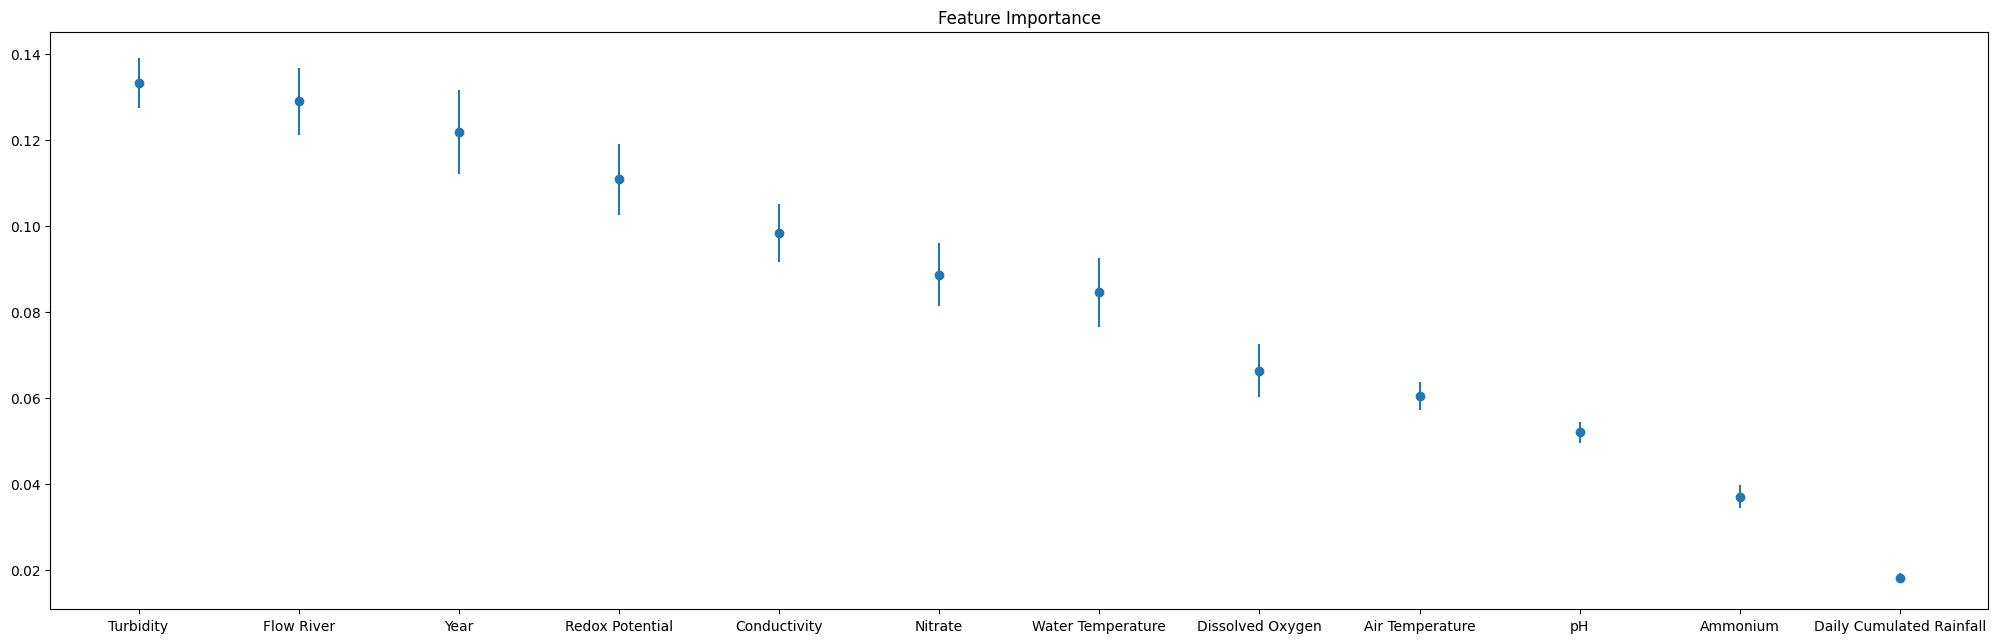

In [151]:
# show the importance of each feature in the model
feature_importance = pd.DataFrame()
feature_importance['feature'] = X_train.columns.difference(['DateTime'])
feature_importance['importance_mean'] = np.mean([estimator.feature_importances_ for estimator in rf_ensemble['estimator']], axis=0)
feature_importance['importance_std'] = np.std([estimator.feature_importances_ for estimator in rf_ensemble['estimator']], axis=0)

feature_importance = feature_importance.sort_values(by='importance_mean', ascending=False)

# plot the importance of each feature with the std
plt.figure(figsize=(25, 7.5))
plt.errorbar(x=feature_importance['feature'], y=feature_importance['importance_mean'], yerr=feature_importance['importance_std'], fmt='o')
plt.title('Feature Importance')
plt.show()

### Predictions

In [152]:
# get predictions
mean_predictions = np.array([estimator.predict(X_test_fit, quantiles=0.5) for estimator in rf_ensemble['estimator']])
lower_bound_predictions = np.array([estimator.predict(X_test_fit, quantiles=0.05) for estimator in rf_ensemble['estimator']])
upper_bound_predictions = np.array([estimator.predict(X_test_fit, quantiles=0.95) for estimator in rf_ensemble['estimator']])

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted wit

In [153]:
mean_predictions = np.mean(mean_predictions, axis=0)
lower_bound_predictions = np.mean(lower_bound_predictions, axis=0)
upper_bound_predictions = np.mean(upper_bound_predictions, axis=0)

In [57]:
%%script false --no-raise-error
# try with best single model
best_model = rf_ensemble['estimator'][3]

mean_predictions = best_model.predict(X_test_fit, quantiles=0.5)
lower_bound_predictions = best_model.predict(X_test_fit, quantiles=0.05)
upper_bound_predictions = best_model.predict(X_test_fit, quantiles=0.95)

In [155]:
rmse = np.sqrt(mean_squared_error(y_test_fit, mean_predictions))
r2 = r2_score(y_test_fit, mean_predictions)

print(f'RMSE: {rmse:.2f}')
print(f'R\u00b2: {r2:.2f}')

RMSE: 4.85
R²: -0.86


### Plots

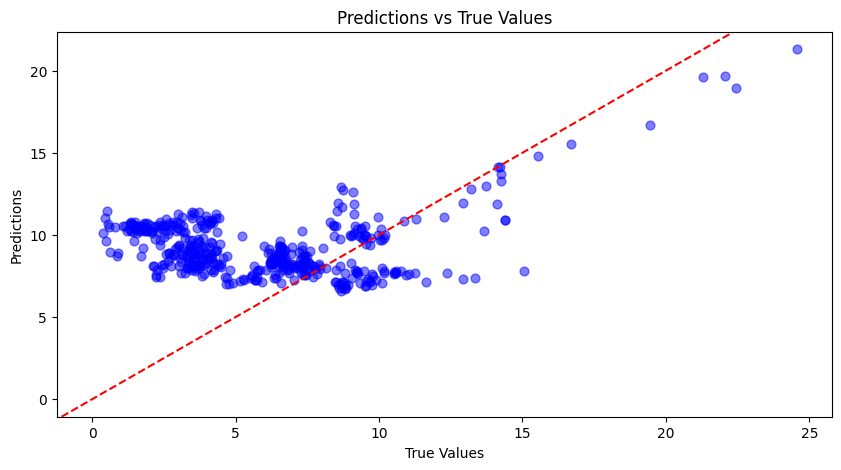

In [156]:
# plot the true vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test_fit.values, mean_predictions, c='b', s=40, alpha=0.5)
plt.axline([0, 0], [1, 1], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'Predictions vs True Values')
plt.show()

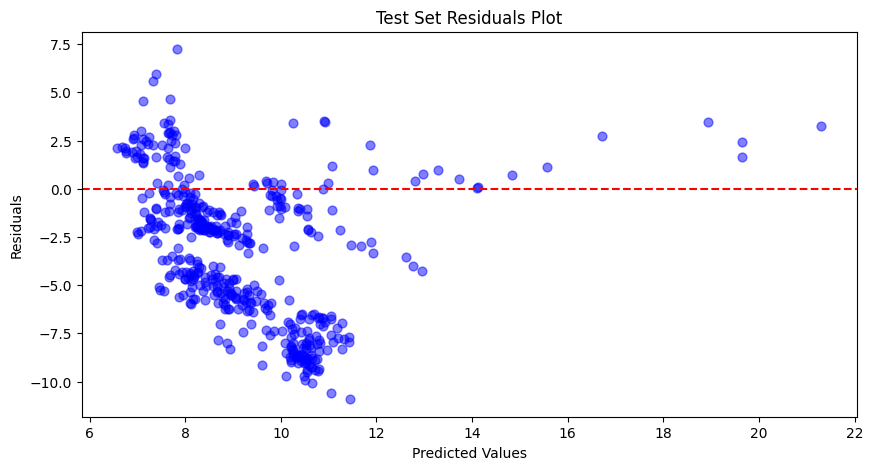

In [157]:
# plot the residuals 
residuals = y_test_fit['Absorbance 254nm'] - mean_predictions
plt.figure(figsize=(10, 5))
plt.scatter(mean_predictions, residuals, c='b', s=40, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Test Set Residuals Plot')
plt.show()

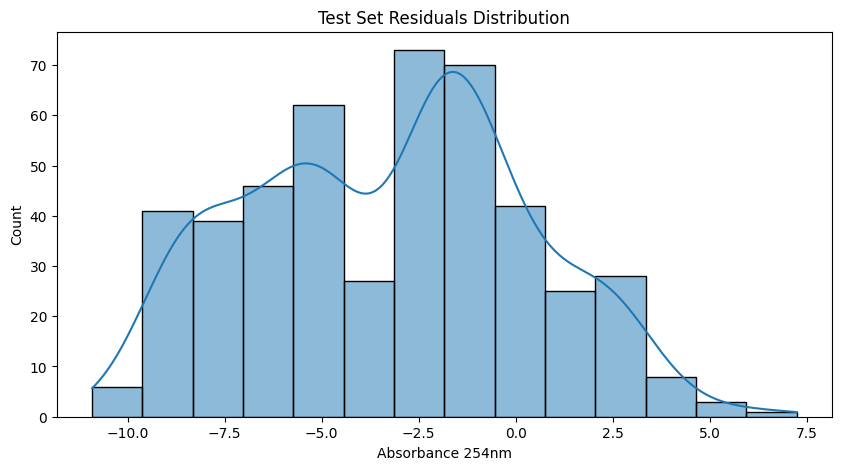

In [158]:
# plot the distribution of the residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title('Test Set Residuals Distribution')
plt.show()

In [159]:
# get training residuals
train_predictions = np.array([estimator.predict(X_train_fit, quantiles=0.5) for estimator in rf_ensemble['estimator']])
train_predictions = np.mean(train_predictions, axis=0)

train_residuals = y_train_fit['Absorbance 254nm'] - train_predictions

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted wit

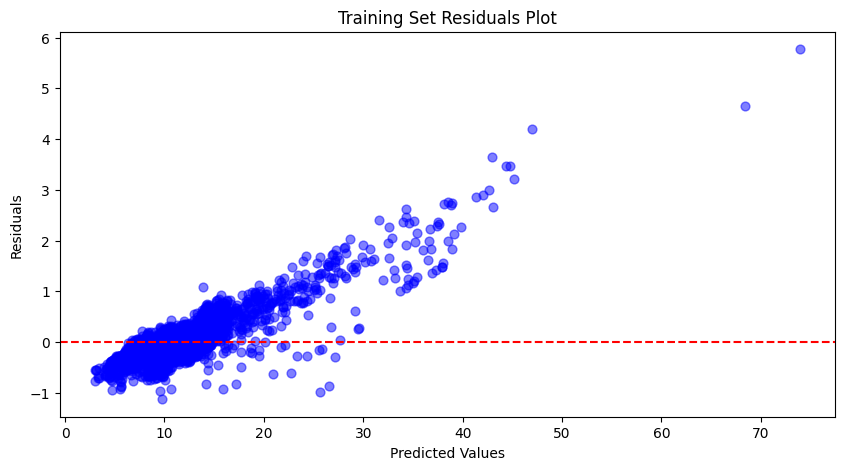

In [160]:
# plot the training residuals
plt.figure(figsize=(10, 5))
plt.scatter(train_predictions, train_residuals, c='b', s=40, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Training Set Residuals Plot')
plt.show()

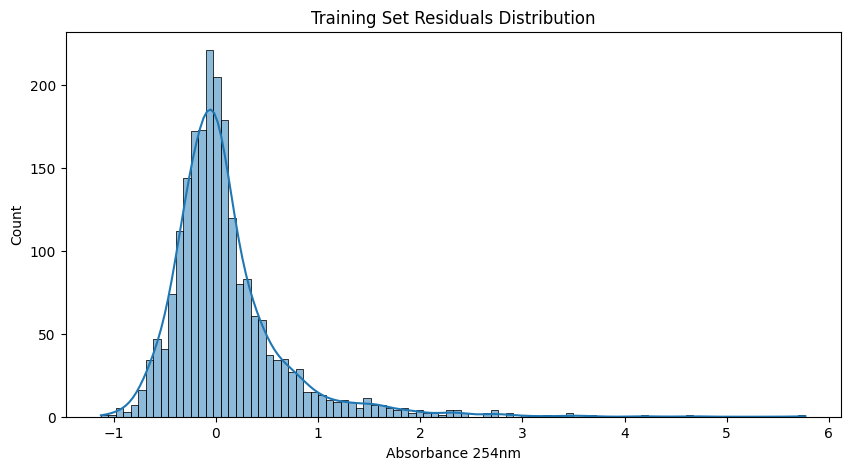

In [161]:
# plot the distribution of the training residuals
plt.figure(figsize=(10, 5))
sns.histplot(train_residuals, kde=True)
plt.title('Training Set Residuals Distribution')
plt.show()

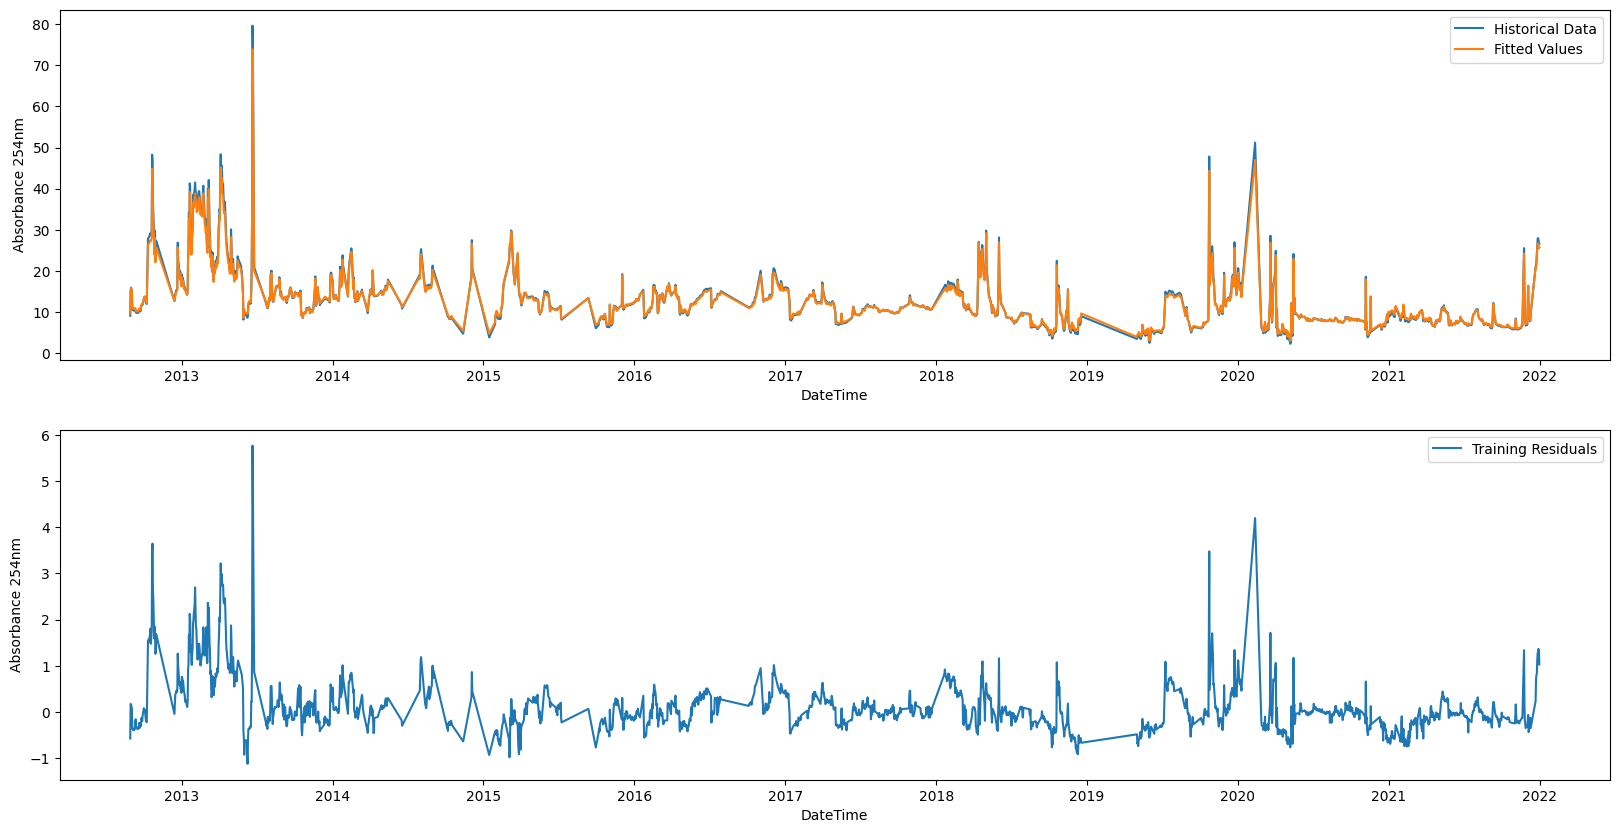

In [162]:
# plot the time series of the residuals and of the train set
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
sns.lineplot(x=y_train['DateTime'], y=y_train['Absorbance 254nm'], label='Historical Data', ax=ax[0])
sns.lineplot(x=y_train['DateTime'], y=train_predictions, label='Fitted Values', ax=ax[0])   

sns.lineplot(x=y_train['DateTime'], y=train_residuals, label='Training Residuals' , ax=ax[1])

plt.show()


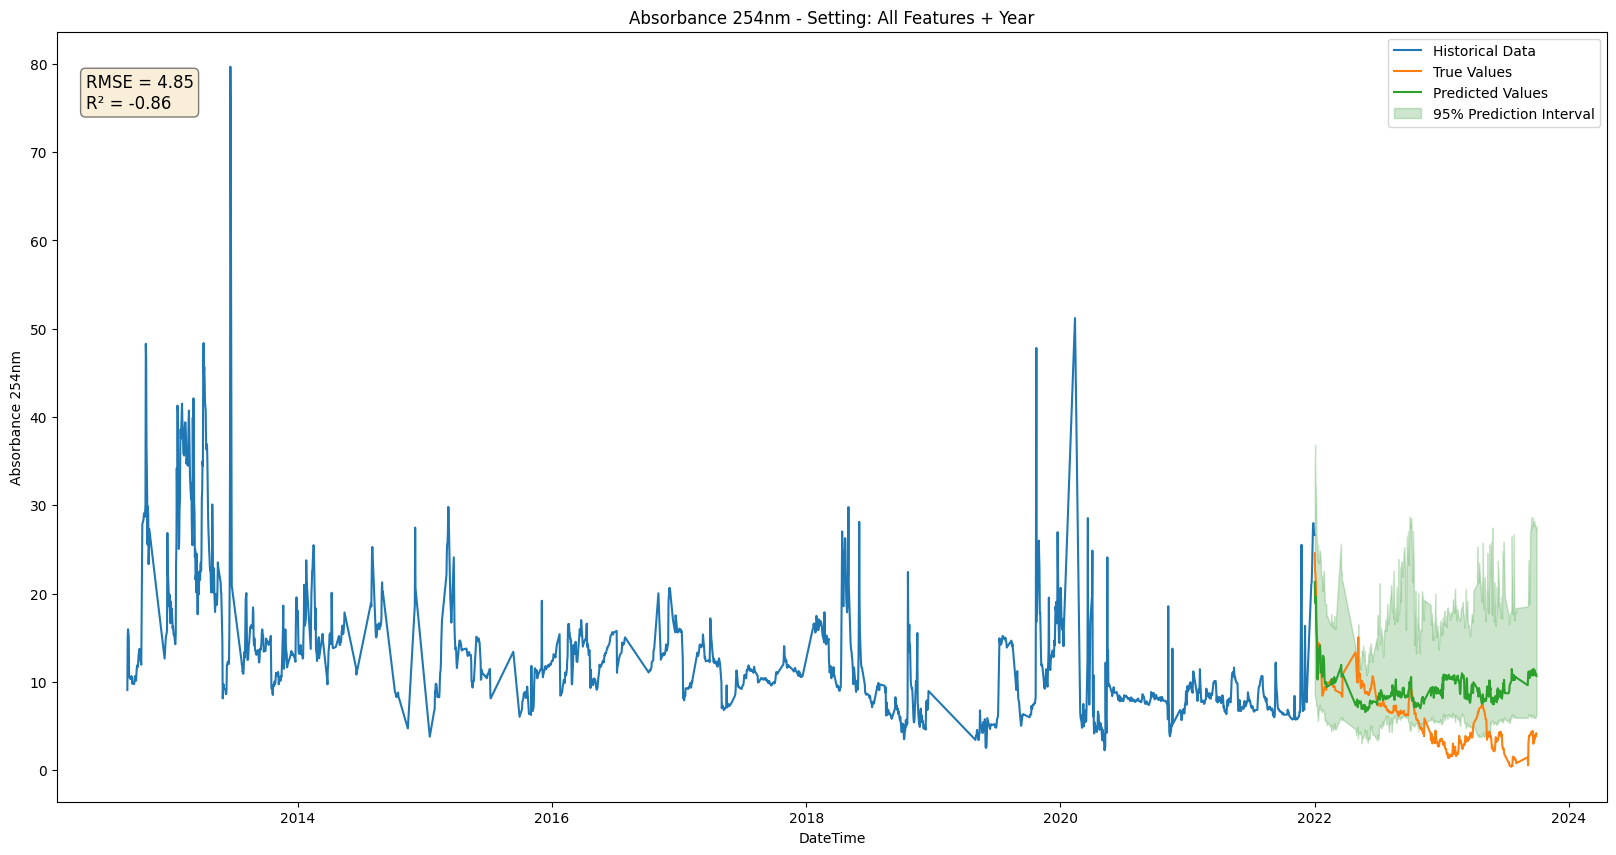

In [163]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=y_train['DateTime'], y=y_train['Absorbance 254nm'], label='Historical Data')
sns.lineplot(x=y_test['DateTime'], y=y_test['Absorbance 254nm'], label='True Values')
sns.lineplot(x=y_test['DateTime'], y=mean_predictions, label='Predicted Values')
# plot std of predictions
plt.fill_between(y_test['DateTime'], lower_bound_predictions, y2=upper_bound_predictions, alpha=0.2, label='95% Prediction Interval', color='g')
plt.xlabel('DateTime')
plt.ylabel('Absorbance 254nm')

# add rmse and r2 to the plot in a box
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

text_string = '\n'.join((
    f'RMSE = {rmse:.2f}',
    f'R\u00b2 = {r2:.2f}',
))

plt.text(y_train['DateTime'].iloc[0] - pd.Timedelta(days=120), 75, s=text_string, fontsize=12, bbox=props)

plt.title(f'Absorbance 254nm - Setting: {setting}')

plt.legend()
plt.show()

Comment: prevede un trend crescente, probabilmente dato da qualche feature 

### Store Results

In [67]:
rf_pred = mean_predictions
rf_lower_bound = lower_bound_predictions
rf_upper_bound = upper_bound_predictions
rf_rmse = rmse
rf_r2 = r2

# Neural Network

In [68]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

## Split Data

In [69]:
def scale_datasets(x_train, x_test):

  """
  Standard Scale test and train data
  Z - Score normalization
  """
  standard_scaler = StandardScaler()
  x_train_scaled = pd.DataFrame(
      standard_scaler.fit_transform(x_train),
      columns=x_train.columns
  )
  x_test_scaled = pd.DataFrame(
      standard_scaler.transform(x_test),
      columns = x_test.columns
  )
  return x_train_scaled, x_test_scaled

In [70]:
X = full_df[full_df.columns.difference(['Absorbance 254nm', 'Season', 'Month', 'Timestamp'])]

y = full_df[['DateTime','Absorbance 254nm']]

In [71]:
# split data such that 2022 and 2023 are test data
X_train = X[X['DateTime'] < '2022-01-01']
X_test = X[X['DateTime'] >= '2022-01-01']

y_train = y[y['DateTime'] < '2022-01-01']
y_test = y[y['DateTime'] >= '2022-01-01']

In [72]:
X_train_fit = X_train[X_train.columns.difference(['DateTime'])]
X_test_fit = X_test[X_test.columns.difference(['DateTime'])]

y_train_fit = y_train[y_train.columns.difference(['DateTime'])]
y_test_fit = y_test[y_test.columns.difference(['DateTime'])]

In [73]:
X_train_scaled, X_test_scaled = scale_datasets(X_train_fit, X_test_fit)

## Define the model

In [74]:
# define and fit the model
def fit_model(X_train, y_train):
    # define neural network model
    features = X_train.shape[1]
    model = Sequential()
    model.add(Dense(10, kernel_initializer='he_normal', activation='relu', input_dim=features))
    model.add(Dense(1))
    # compile the model and specify loss and optimizer
    opt = Adam(learning_rate=0.01, beta_1=0.85, beta_2=0.999)
    model.compile(optimizer=opt, loss='mse')
    # fit the model on the training dataset
    model.fit(X_train, y_train, verbose=0, epochs=300, batch_size=16)
    return model

In [75]:
# fit an ensemble of models
def fit_ensemble(n_members, X_train, X_test, y_train, y_test):
    ensemble = list()
    for i in range(n_members):
    # define and fit the model on the training set
        model = fit_model(X_train, y_train)
        # evaluate model on the test set
        yhat = model.predict(X_test, verbose=0)
        rmse = np.sqrt(mean_squared_error(y_test, yhat))
        print('>%d, RMSE: %.3f' % (i+1, rmse))
        # store the model
        ensemble.append(model)
    return ensemble

In [76]:
def get_errors(ensemble, X_train, y_train):
    errors = list()
    for model in ensemble:
        yhat = model.predict(X_train, verbose=0)
        error = np.sqrt(mean_squared_error(y_train, yhat))
        errors.append(error)
    return errors

In [77]:
# make predictions with the ensemble and calculate a prediction interval
def predict_with_pi(ensemble, X):
    # make predictions
    yhat = [model.predict(X, verbose=0) for model in ensemble]
    yhat = np.asarray(yhat)
    yhat = yhat.reshape(yhat.shape[0], yhat.shape[1])
    # calculate 95% gaussian prediction interval
    stds = np.std(yhat, axis=0)
    interval = 1.96 * stds
    means = np.mean(yhat, axis=0)
    lower, upper = means - interval, means + interval
    return lower, means, upper

In [78]:
%%script false --no-raise-error
hidden_units1 = 160
hidden_units2 = 480
hidden_units3 = 256
learning_rate = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model = Sequential([
    Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model

In [79]:
%%script false --no-raise-error
model = build_model_using_sequential()

In [80]:
%%script false --no-raise-error
# loss function
msle = MeanSquaredLogarithmicError()
model.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate), 
    metrics=[msle]
)

## Train the model

### Hyperparameter Tuning

In [ ]:
exp_dir = 'experiments'

def createfolders_and_callbacks(model_name):

    callbacks = []

    # Model checkpoint
    # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
        save_weights_only=False, # True to save only weights
        save_freq=110
    ) # True to save only the best epoch
    
    callbacks.append(ckpt_callback)


    # Early Stopping
    # --------------
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_msle', patience=50, restore_best_weights=True, mode='min')

    callbacks.append(es_callback)


    return callbacks

In [180]:
from sklearn import model_selection


def objective(trial):

    hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
    hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)
    kernel_initializer = trial.suggest_categorical("kernel_initializer", ["normal", "he_normal", "lecun_normal"])
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid", "linear"])
    dropout = trial.suggest_float("dropout", 0.1, 0.5, log=True)
    learning_rate = trial.suggest_float("learning_rate", 0.0001, 0.1, log=True)
    
    model = Sequential([
        Dense(hidden_units1, kernel_initializer=kernel_initializer, activation=activation),
        Dropout(dropout),
        Dense(hidden_units2, kernel_initializer=kernel_initializer, activation=activation),
        Dropout(dropout),
        Dense(1, kernel_initializer=kernel_initializer, activation='linear')
    ])
    
    msle = MeanSquaredLogarithmicError()
    
    model.compile(
        loss=msle, 
        optimizer=Adam(learning_rate=learning_rate), 
        metrics=[msle],
    )
    
    # evaluate the model with cross validation
    cv = model_selection.KFold(n_splits=5)
    
    rmses = []
    
    for train_index, test_index in cv.split(X_train_scaled):
        X_train_cv, X_test_cv = X_train_scaled.iloc[train_index], X_train_scaled.iloc[test_index]
        y_train_cv, y_test_cv = y_train_fit.iloc[train_index], y_train_fit.iloc[test_index]
        
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='mean_squared_logarithmic_error', patience=10, restore_best_weights=True, mode='min')
        
        model.fit(X_train_cv, y_train_cv, epochs=30, batch_size=16, verbose=0, callbacks=[es_callback])
        
        yhat = model.predict(X_test_cv, verbose=0)
        
        rmse = np.sqrt(mean_squared_error(y_test_cv, yhat))
        
        rmses.append(rmse)
    
    return np.mean(rmses)

In [181]:
study = optuna.create_study(
    direction="minimize",
    storage="sqlite:///NeuralNetwork.sqlite3",
    study_name="Hyperparameter Tuning - All Features + Year",
    load_if_exists=True,
)
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2024-03-14 18:51:05,080] Using an existing study with name 'Hyperparameter Tuning - All Features + Year' instead of creating a new one.


  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:51:12,738] Trial 55 finished with value: 4.567534167679417 and parameters: {'hidden_units1': 15, 'hidden_units2': 10, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.29667011815156513, 'learning_rate': 0.0015434624455246291}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:51:20,696] Trial 56 finished with value: 4.809973027692268 and parameters: {'hidden_units1': 10, 'hidden_units2': 9, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.3476335547911311, 'learning_rate': 0.0020436164010061183}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:51:28,699] Trial 57 finished with value: 4.695857301808705 and parameters: {'hidden_units1': 17, 'hidden_units2': 10, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.3206451255295979, 'learning_rate': 0.0006556717280252337}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:51:37,487] Trial 58 finished with value: 5.358917606809368 and parameters: {'hidden_units1': 13, 'hidden_units2': 4, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.2659260430693098, 'learning_rate': 0.0003715378117371423}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:51:43,186] Trial 59 finished with value: 13.939520918058534 and parameters: {'hidden_units1': 9, 'hidden_units2': 3, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.38931464492531037, 'learning_rate': 0.004642097661657613}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:51:50,796] Trial 60 finished with value: 4.944493659978853 and parameters: {'hidden_units1': 1, 'hidden_units2': 5, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.148206176695481, 'learning_rate': 0.0025374949087975224}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:51:55,725] Trial 61 finished with value: 13.759970473241609 and parameters: {'hidden_units1': 12, 'hidden_units2': 3, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.1706488371386346, 'learning_rate': 0.0014430292350473496}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:52:03,776] Trial 62 finished with value: 4.60863453002365 and parameters: {'hidden_units1': 16, 'hidden_units2': 4, 'kernel_initializer': 'normal', 'activation': 'relu', 'dropout': 0.4239695086422753, 'learning_rate': 0.0009460204371158795}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:52:10,421] Trial 63 finished with value: 4.890683743052087 and parameters: {'hidden_units1': 14, 'hidden_units2': 6, 'kernel_initializer': 'lecun_normal', 'activation': 'linear', 'dropout': 0.24372720975303047, 'learning_rate': 0.007594780560805783}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:52:18,236] Trial 64 finished with value: 4.582754557952286 and parameters: {'hidden_units1': 14, 'hidden_units2': 8, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.3076340029740019, 'learning_rate': 0.0008914183494380674}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:52:26,029] Trial 65 finished with value: 4.87942794883997 and parameters: {'hidden_units1': 15, 'hidden_units2': 7, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.27821851053211905, 'learning_rate': 0.0012659334811000813}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:52:33,531] Trial 66 finished with value: 4.538419651863178 and parameters: {'hidden_units1': 12, 'hidden_units2': 10, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.28933526872249415, 'learning_rate': 0.0011430020045318104}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:52:41,333] Trial 67 finished with value: 4.983429274892485 and parameters: {'hidden_units1': 12, 'hidden_units2': 10, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.28996782301057766, 'learning_rate': 0.0006078125970265736}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:52:48,971] Trial 68 finished with value: 5.615224592663571 and parameters: {'hidden_units1': 8, 'hidden_units2': 9, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.13212227447818453, 'learning_rate': 0.00025321267533365407}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:52:56,743] Trial 69 finished with value: 5.268138188854125 and parameters: {'hidden_units1': 11, 'hidden_units2': 10, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.341874551552429, 'learning_rate': 0.0003700802135286245}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:53:04,495] Trial 70 finished with value: 4.66085946710615 and parameters: {'hidden_units1': 18, 'hidden_units2': 9, 'kernel_initializer': 'normal', 'activation': 'relu', 'dropout': 0.25618352517424914, 'learning_rate': 0.0007608219629842857}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:53:12,235] Trial 71 finished with value: 5.360931049369151 and parameters: {'hidden_units1': 13, 'hidden_units2': 5, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.3169095026112099, 'learning_rate': 0.0004363494055639991}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:53:19,900] Trial 72 finished with value: 5.628392715764086 and parameters: {'hidden_units1': 20, 'hidden_units2': 2, 'kernel_initializer': 'he_normal', 'activation': 'tanh', 'dropout': 0.12569668398737877, 'learning_rate': 0.002079880532845022}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:53:27,688] Trial 73 finished with value: 5.553499218660316 and parameters: {'hidden_units1': 15, 'hidden_units2': 10, 'kernel_initializer': 'lecun_normal', 'activation': 'sigmoid', 'dropout': 0.21704908818405666, 'learning_rate': 0.001133246818994095}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:53:35,276] Trial 74 finished with value: 4.613314242938899 and parameters: {'hidden_units1': 14, 'hidden_units2': 8, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.2979372489472831, 'learning_rate': 0.0011291851990481898}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:53:42,304] Trial 75 finished with value: 4.733551820479157 and parameters: {'hidden_units1': 12, 'hidden_units2': 9, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.2772135785330181, 'learning_rate': 0.0015115061974402167}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:53:49,671] Trial 76 finished with value: 4.485601303844324 and parameters: {'hidden_units1': 13, 'hidden_units2': 6, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.375764092163921, 'learning_rate': 0.003822805676859915}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:53:56,953] Trial 77 finished with value: 4.576487804659017 and parameters: {'hidden_units1': 13, 'hidden_units2': 6, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.3812155082577706, 'learning_rate': 0.004503285365662266}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:54:03,589] Trial 78 finished with value: 4.542057728470095 and parameters: {'hidden_units1': 12, 'hidden_units2': 6, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.36630845225192105, 'learning_rate': 0.00369623533696961}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:54:09,872] Trial 79 finished with value: 5.00276321645833 and parameters: {'hidden_units1': 11, 'hidden_units2': 5, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.4342557100072519, 'learning_rate': 0.006024040959476137}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:54:16,713] Trial 80 finished with value: 4.775777970004048 and parameters: {'hidden_units1': 12, 'hidden_units2': 6, 'kernel_initializer': 'normal', 'activation': 'relu', 'dropout': 0.3732693703045525, 'learning_rate': 0.010688529341873755}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:54:24,322] Trial 81 finished with value: 4.782534120807923 and parameters: {'hidden_units1': 10, 'hidden_units2': 4, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.36160167367538393, 'learning_rate': 0.0037046451781173055}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:54:31,753] Trial 82 finished with value: 4.769325363736575 and parameters: {'hidden_units1': 13, 'hidden_units2': 5, 'kernel_initializer': 'lecun_normal', 'activation': 'linear', 'dropout': 0.41000700973805076, 'learning_rate': 0.0026844240156435116}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:54:39,056] Trial 83 finished with value: 4.78982916295117 and parameters: {'hidden_units1': 12, 'hidden_units2': 7, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.3253694166348317, 'learning_rate': 0.005512150826617049}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:54:46,902] Trial 84 finished with value: 4.516363752036208 and parameters: {'hidden_units1': 11, 'hidden_units2': 6, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.3472195495896661, 'learning_rate': 0.003649323311997361}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:54:55,429] Trial 85 finished with value: 4.702554758947024 and parameters: {'hidden_units1': 11, 'hidden_units2': 6, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.3412760563945587, 'learning_rate': 0.0028645261812029524}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:55:03,365] Trial 86 finished with value: 4.761745488545446 and parameters: {'hidden_units1': 11, 'hidden_units2': 6, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.35501885779667963, 'learning_rate': 0.00383616348867418}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:55:11,911] Trial 87 finished with value: 4.71993505953973 and parameters: {'hidden_units1': 10, 'hidden_units2': 3, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.3325304208360506, 'learning_rate': 0.0019699008428496695}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:55:19,854] Trial 88 finished with value: 7.32122724656706 and parameters: {'hidden_units1': 8, 'hidden_units2': 4, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.46294593969552605, 'learning_rate': 0.00010571450494491615}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:55:27,019] Trial 89 finished with value: 4.956101445111721 and parameters: {'hidden_units1': 14, 'hidden_units2': 5, 'kernel_initializer': 'he_normal', 'activation': 'relu', 'dropout': 0.3698090249825844, 'learning_rate': 0.005108439875935353}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:55:35,123] Trial 90 finished with value: 5.340003740763896 and parameters: {'hidden_units1': 13, 'hidden_units2': 7, 'kernel_initializer': 'normal', 'activation': 'tanh', 'dropout': 0.19940146826275426, 'learning_rate': 0.007344429599291287}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:55:42,514] Trial 91 finished with value: 6.067241115249878 and parameters: {'hidden_units1': 10, 'hidden_units2': 6, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.38565945881011704, 'learning_rate': 0.0002123384521463185}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:55:50,251] Trial 92 finished with value: 5.567329816335773 and parameters: {'hidden_units1': 9, 'hidden_units2': 5, 'kernel_initializer': 'lecun_normal', 'activation': 'sigmoid', 'dropout': 0.14875371078501567, 'learning_rate': 0.0033652258416989084}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:55:58,803] Trial 93 finished with value: 4.528938415087061 and parameters: {'hidden_units1': 12, 'hidden_units2': 4, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.1082201546593848, 'learning_rate': 0.0024558811272086495}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:56:09,281] Trial 94 finished with value: 4.553398964295549 and parameters: {'hidden_units1': 12, 'hidden_units2': 4, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.11155356866497615, 'learning_rate': 0.00241950275283895}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:56:20,770] Trial 95 finished with value: 5.749969000739244 and parameters: {'hidden_units1': 12, 'hidden_units2': 4, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.10376744879485793, 'learning_rate': 0.00016242429018738068}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:56:29,850] Trial 96 finished with value: 4.851397124225646 and parameters: {'hidden_units1': 11, 'hidden_units2': 3, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.3099606488092618, 'learning_rate': 0.0019228188228625196}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:56:36,590] Trial 97 finished with value: 14.469018426817678 and parameters: {'hidden_units1': 13, 'hidden_units2': 5, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.11380662110150362, 'learning_rate': 0.0016711170580957662}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:56:44,922] Trial 98 finished with value: 4.96915972664149 and parameters: {'hidden_units1': 15, 'hidden_units2': 6, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.17939929838127294, 'learning_rate': 0.0030714692989918563}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:56:49,944] Trial 99 finished with value: 13.55848015878866 and parameters: {'hidden_units1': 12, 'hidden_units2': 2, 'kernel_initializer': 'normal', 'activation': 'relu', 'dropout': 0.3505685768769095, 'learning_rate': 0.003734444450153965}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:56:58,110] Trial 100 finished with value: 4.522621175171552 and parameters: {'hidden_units1': 13, 'hidden_units2': 10, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.12766793164936793, 'learning_rate': 0.0013612525579285448}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:57:06,536] Trial 101 finished with value: 4.581780637244464 and parameters: {'hidden_units1': 14, 'hidden_units2': 10, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.12366395069554303, 'learning_rate': 0.0014248010973380463}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:57:14,133] Trial 102 finished with value: 4.956165430849816 and parameters: {'hidden_units1': 13, 'hidden_units2': 10, 'kernel_initializer': 'lecun_normal', 'activation': 'linear', 'dropout': 0.13605033554657253, 'learning_rate': 0.000597340704252524}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:57:22,523] Trial 103 finished with value: 4.734645859609174 and parameters: {'hidden_units1': 14, 'hidden_units2': 10, 'kernel_initializer': 'he_normal', 'activation': 'relu', 'dropout': 0.14492134041180926, 'learning_rate': 0.0021687035384504723}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:57:30,789] Trial 104 finished with value: 4.905664977759981 and parameters: {'hidden_units1': 11, 'hidden_units2': 3, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.12732681816090488, 'learning_rate': 0.0017478934387663897}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:57:38,564] Trial 105 finished with value: 4.649656249362047 and parameters: {'hidden_units1': 12, 'hidden_units2': 9, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.11554531295790368, 'learning_rate': 0.0024265554035497743}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:57:46,867] Trial 106 finished with value: 4.839674189664192 and parameters: {'hidden_units1': 13, 'hidden_units2': 10, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.16223667347808535, 'learning_rate': 0.0027312666560054886}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:57:54,626] Trial 107 finished with value: 4.687179224726706 and parameters: {'hidden_units1': 13, 'hidden_units2': 6, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.10599703559172453, 'learning_rate': 0.0012990530017646233}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:58:02,527] Trial 108 finished with value: 5.0329936247935105 and parameters: {'hidden_units1': 11, 'hidden_units2': 7, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.2909732437564148, 'learning_rate': 0.0042439660390467355}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:58:10,775] Trial 109 finished with value: 4.754521868569938 and parameters: {'hidden_units1': 15, 'hidden_units2': 5, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.12223676798059507, 'learning_rate': 0.001058712648852468}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:58:16,645] Trial 110 finished with value: 13.55956781198348 and parameters: {'hidden_units1': 5, 'hidden_units2': 4, 'kernel_initializer': 'normal', 'activation': 'relu', 'dropout': 0.31613386579260516, 'learning_rate': 0.0002608489453040323}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:58:25,092] Trial 111 finished with value: 5.849043151994988 and parameters: {'hidden_units1': 12, 'hidden_units2': 10, 'kernel_initializer': 'lecun_normal', 'activation': 'tanh', 'dropout': 0.13365726885504786, 'learning_rate': 0.000838039961716953}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:58:33,918] Trial 112 finished with value: 5.326275592913781 and parameters: {'hidden_units1': 10, 'hidden_units2': 5, 'kernel_initializer': 'lecun_normal', 'activation': 'sigmoid', 'dropout': 0.3307549007425195, 'learning_rate': 0.006919222528465022}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:58:42,764] Trial 113 finished with value: 4.495232062960394 and parameters: {'hidden_units1': 14, 'hidden_units2': 6, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.1408473308405997, 'learning_rate': 0.0015429170058416427}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:58:51,320] Trial 114 finished with value: 4.71399833085255 and parameters: {'hidden_units1': 14, 'hidden_units2': 6, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.15534716914462862, 'learning_rate': 0.0014356425698986033}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:59:01,090] Trial 115 finished with value: 4.524017849199677 and parameters: {'hidden_units1': 16, 'hidden_units2': 6, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.13982444188269288, 'learning_rate': 0.0016710792744299534}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:59:10,147] Trial 116 finished with value: 4.650883825052206 and parameters: {'hidden_units1': 17, 'hidden_units2': 6, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.1431227246983302, 'learning_rate': 0.0016759746985494347}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:59:19,548] Trial 117 finished with value: 4.421689561153726 and parameters: {'hidden_units1': 16, 'hidden_units2': 7, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.14296433627124847, 'learning_rate': 0.0009695031149297497}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:59:25,323] Trial 118 finished with value: 14.048081584650749 and parameters: {'hidden_units1': 16, 'hidden_units2': 7, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.13853757437711553, 'learning_rate': 0.00013758958639524155}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:59:34,201] Trial 119 finished with value: 4.9523370998622465 and parameters: {'hidden_units1': 18, 'hidden_units2': 7, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.15175921156354358, 'learning_rate': 0.0012991838585106406}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:59:42,573] Trial 120 finished with value: 4.640455780171325 and parameters: {'hidden_units1': 16, 'hidden_units2': 6, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.1411374774971357, 'learning_rate': 0.0009659356999210956}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:59:51,485] Trial 121 finished with value: 4.891877474028035 and parameters: {'hidden_units1': 15, 'hidden_units2': 6, 'kernel_initializer': 'normal', 'activation': 'relu', 'dropout': 0.1320532997848909, 'learning_rate': 0.002131689760252128}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 18:59:59,821] Trial 122 finished with value: 4.656481844446531 and parameters: {'hidden_units1': 17, 'hidden_units2': 7, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.12908240328828136, 'learning_rate': 0.0018178820308386516}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 19:00:09,245] Trial 123 finished with value: 5.220005368175601 and parameters: {'hidden_units1': 15, 'hidden_units2': 5, 'kernel_initializer': 'lecun_normal', 'activation': 'linear', 'dropout': 0.11840729271260399, 'learning_rate': 0.00043891433013819856}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 19:00:17,727] Trial 124 finished with value: 4.487977898436055 and parameters: {'hidden_units1': 14, 'hidden_units2': 9, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.14805729007926904, 'learning_rate': 0.0011786322912679507}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 19:00:26,506] Trial 125 finished with value: 4.689672862184228 and parameters: {'hidden_units1': 14, 'hidden_units2': 9, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.14813142624215925, 'learning_rate': 0.0016063744097480248}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 19:00:35,698] Trial 126 finished with value: 4.399808277161303 and parameters: {'hidden_units1': 16, 'hidden_units2': 4, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.17193570768455907, 'learning_rate': 0.0010476836370100116}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 19:00:44,505] Trial 127 finished with value: 4.456460244323543 and parameters: {'hidden_units1': 16, 'hidden_units2': 8, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.15669730745831803, 'learning_rate': 0.0009798076657287662}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 19:00:52,504] Trial 128 finished with value: 4.700224090455014 and parameters: {'hidden_units1': 15, 'hidden_units2': 8, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.16072051573221904, 'learning_rate': 0.0007169789347580551}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 19:01:01,885] Trial 129 finished with value: 4.7183968311357365 and parameters: {'hidden_units1': 17, 'hidden_units2': 8, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.17182374387131574, 'learning_rate': 0.0010112328299933058}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 19:01:10,485] Trial 130 finished with value: 4.477059868371454 and parameters: {'hidden_units1': 16, 'hidden_units2': 8, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.16108578728871437, 'learning_rate': 0.0008620727233104557}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 19:01:18,148] Trial 131 finished with value: 4.701582587172068 and parameters: {'hidden_units1': 16, 'hidden_units2': 8, 'kernel_initializer': 'he_normal', 'activation': 'relu', 'dropout': 0.1640469571495645, 'learning_rate': 0.0008303435452571456}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 19:01:26,535] Trial 132 finished with value: 4.686397181501501 and parameters: {'hidden_units1': 18, 'hidden_units2': 8, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.1552158755045293, 'learning_rate': 0.0005652869462689419}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 19:01:34,994] Trial 133 finished with value: 6.316995280421545 and parameters: {'hidden_units1': 15, 'hidden_units2': 7, 'kernel_initializer': 'normal', 'activation': 'tanh', 'dropout': 0.1720736541920649, 'learning_rate': 0.0006684846824070447}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 19:01:44,226] Trial 134 finished with value: 4.5626251469708645 and parameters: {'hidden_units1': 16, 'hidden_units2': 9, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.14440868367315418, 'learning_rate': 0.0011184970908916956}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 19:01:53,171] Trial 135 finished with value: 4.559945874880661 and parameters: {'hidden_units1': 14, 'hidden_units2': 9, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.150085123742837, 'learning_rate': 0.0009159749082561008}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 19:02:02,709] Trial 136 finished with value: 4.541201097398952 and parameters: {'hidden_units1': 18, 'hidden_units2': 8, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.1351261762399731, 'learning_rate': 0.001233455606270045}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 19:02:10,301] Trial 137 finished with value: 4.681323931803703 and parameters: {'hidden_units1': 17, 'hidden_units2': 9, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.18218260373050266, 'learning_rate': 0.00033377164367957065}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 19:02:18,770] Trial 138 finished with value: 4.696446909586825 and parameters: {'hidden_units1': 2, 'hidden_units2': 7, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.1617829369366248, 'learning_rate': 0.000816298610845651}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 19:02:27,730] Trial 139 finished with value: 4.541469660332622 and parameters: {'hidden_units1': 19, 'hidden_units2': 8, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.15644415872229356, 'learning_rate': 0.0014251644593690413}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)


[I 2024-03-14 19:02:36,540] Trial 140 finished with value: 6.596812332465961 and parameters: {'hidden_units1': 14, 'hidden_units2': 7, 'kernel_initializer': 'lecun_normal', 'activation': 'sigmoid', 'dropout': 0.14634103865989723, 'learning_rate': 0.0004982758730253864}. Best is trial 0 with value: 4.312315226602498.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units1 = trial.suggest_int("hidden_units1", 1, 20, 1)
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_units2 = trial.suggest_int("hidden_units2", 1, 10, 1)
2024-03-14 19:02:40.543290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0] vs. [2]
	 [[{{node sequential_235_1/dense_696_1/add}}]]


[W 2024-03-14 19:02:40,549] Trial 141 failed with parameters: {'hidden_units1': 15, 'hidden_units2': 2, 'kernel_initializer': 'lecun_normal', 'activation': 'relu', 'dropout': 0.12796434977764123, 'learning_rate': 0.0010627423579350243} because of the following error: InvalidArgumentError().
Traceback (most recent call last):
  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py", line 42, in objective
    yhat = model.predict(X_test_cv, verbose=0)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 123, in error_handler
    raise e.with_traceback(fi

InvalidArgumentError: Graph execution error:

Detected at node sequential_235_1/dense_696_1/add defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/homebrew/Cellar/python@3.12/3.12.0/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 618, in run_forever

  File "/opt/homebrew/Cellar/python@3.12/3.12.0/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 1951, in _run_once

  File "/opt/homebrew/Cellar/python@3.12/3.12.0/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py", line 84, in _run

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/827659400.py", line 7, in <module>

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/optuna/study/study.py", line 451, in optimize

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/optuna/study/_optimize.py", line 66, in _optimize

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/optuna/study/_optimize.py", line 163, in _optimize_sequential

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/optuna/study/_optimize.py", line 200, in _run_trial

  File "/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/4044350142.py", line 42, in objective

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 513, in predict

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 212, in one_step_on_data_distributed

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 201, in one_step_on_data

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 93, in predict_step

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/layer.py", line 816, in __call__

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/ops/operation.py", line 42, in __call__

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 157, in error_handler

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/models/sequential.py", line 203, in call

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/models/functional.py", line 188, in call

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/ops/function.py", line 153, in _run_through_graph

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/models/functional.py", line 572, in call

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/layer.py", line 816, in __call__

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/ops/operation.py", line 42, in __call__

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 157, in error_handler

  File "/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py", line 139, in call

Incompatible shapes: [0] vs. [2]
	 [[{{node sequential_235_1/dense_696_1/add}}]] [Op:__inference_one_step_on_data_distributed_15193240]

In [ ]:
study.best_params

In [81]:
%%script false --no-raise-error
history = model.fit(
    X_train_scaled.values, 
    y_train_fit.values, 
    epochs=50, 
    batch_size=64,
    validation_split=0.2,
    verbose=1,
)

In [82]:
%%script false --no-raise-error
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

In [83]:
n_members = 10

ensemble = fit_ensemble(
    n_members,
    X_train_scaled.values,
    X_test_scaled.values,
    y_train_fit.values,
    y_test_fit.values
)

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>1, RMSE: 4.558


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>2, RMSE: 7.361


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>3, RMSE: 4.934


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>4, RMSE: 3.775


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>5, RMSE: 4.745


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>6, RMSE: 5.152


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>7, RMSE: 5.096


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>8, RMSE: 5.259


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>9, RMSE: 5.084


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>10, RMSE: 4.862


In [84]:
train_rmses = get_errors(ensemble, X_train_scaled.values, y_train_fit.values)

In [85]:
train_rmses

[2.8065529834675282,
 2.8414461676398375,
 2.8078205804442518,
 2.7620418751317093,
 3.0121860449353224,
 2.741094864905808,
 2.673158338928589,
 3.06329302966494,
 2.7360311754597633,
 2.8353602119388177]

## Prediction

In [86]:
%%script false --no-raise-error
y_pred = model.predict(X_test_scaled)

In [87]:
(lower_bound, y_pred, upper_bound) = predict_with_pi(ensemble, X_test_scaled)

## Plots

In [88]:
rmse = np.sqrt(mean_squared_error(y_test_fit, y_pred))
r2 = r2_score(y_test_fit, y_pred)

print(f'RMSE: {rmse:.2f}')
print(f'R\u00b2: {r2:.2f}')

RMSE: 4.29
R²: -0.45


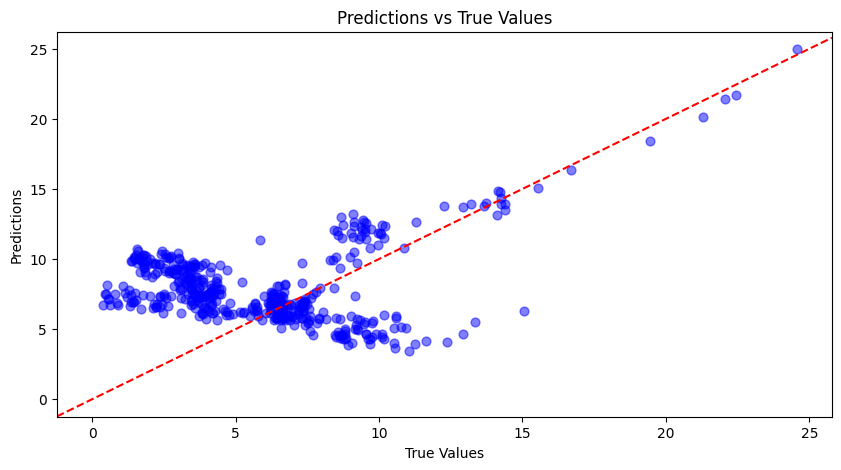

In [89]:
# plot the true vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test_fit, y_pred, c='b', s=40, alpha=0.5)
plt.axline([0, 0], [1, 1], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'Predictions vs True Values')
plt.show()

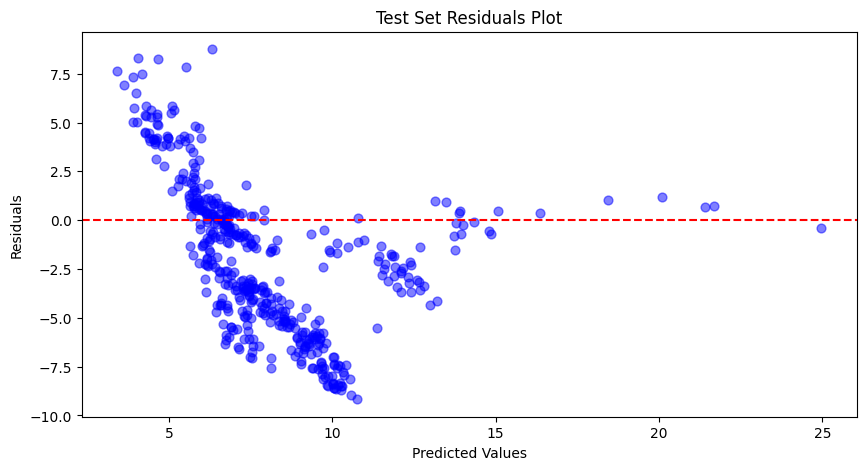

In [90]:
# plot the residuals 
residuals = y_test_fit['Absorbance 254nm'] - y_pred.flatten()
plt.figure(figsize=(10, 5))
plt.scatter(y_pred.flatten(), residuals, c='b', s=40, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Test Set Residuals Plot')
plt.show()

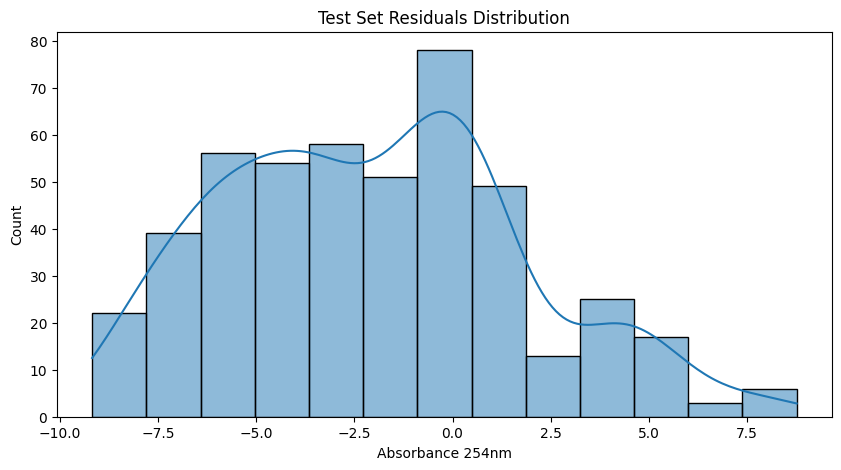

In [91]:
# plot the distribution of the residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title('Test Set Residuals Distribution')
plt.show()

In [92]:
# get training residuals
(_, train_predictions, _) = predict_with_pi(ensemble, X_train_scaled)
train_residuals = y_train_fit['Absorbance 254nm'] - train_predictions

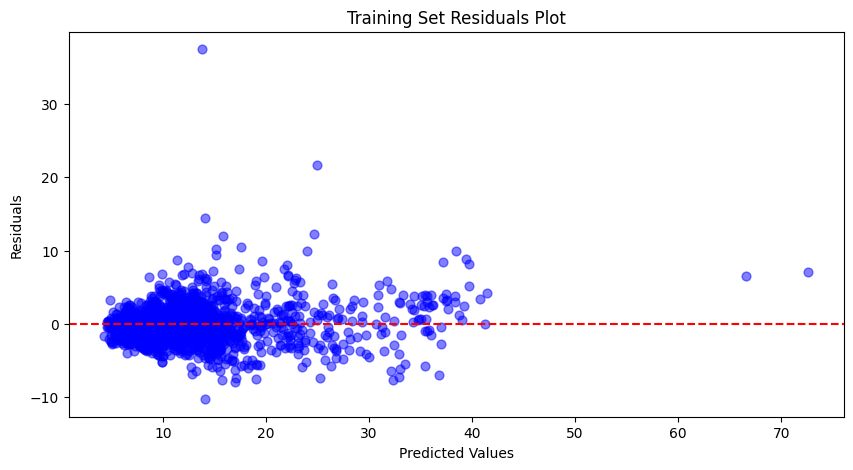

In [93]:
# plot the training residuals
plt.figure(figsize=(10, 5))
plt.scatter(train_predictions.flatten(), train_residuals, c='b', s=40, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Training Set Residuals Plot')
plt.show()

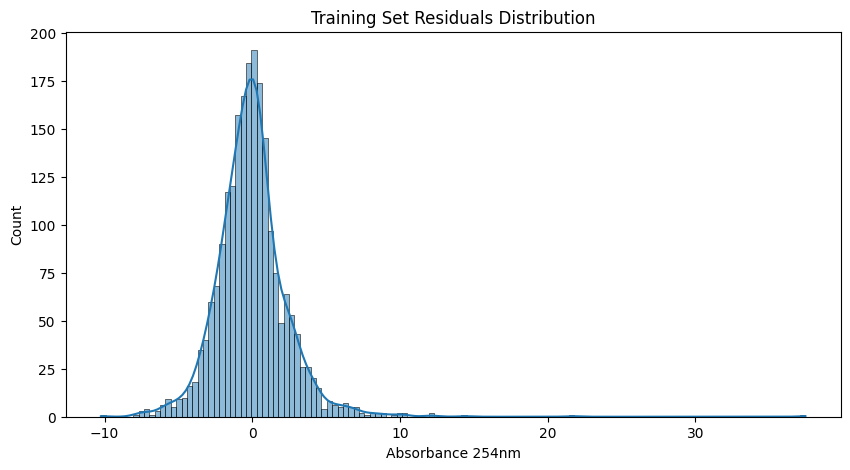

In [94]:
# plot the distribution of the training residuals
plt.figure(figsize=(10, 5))
sns.histplot(train_residuals, kde=True)
plt.title('Training Set Residuals Distribution')
plt.show()

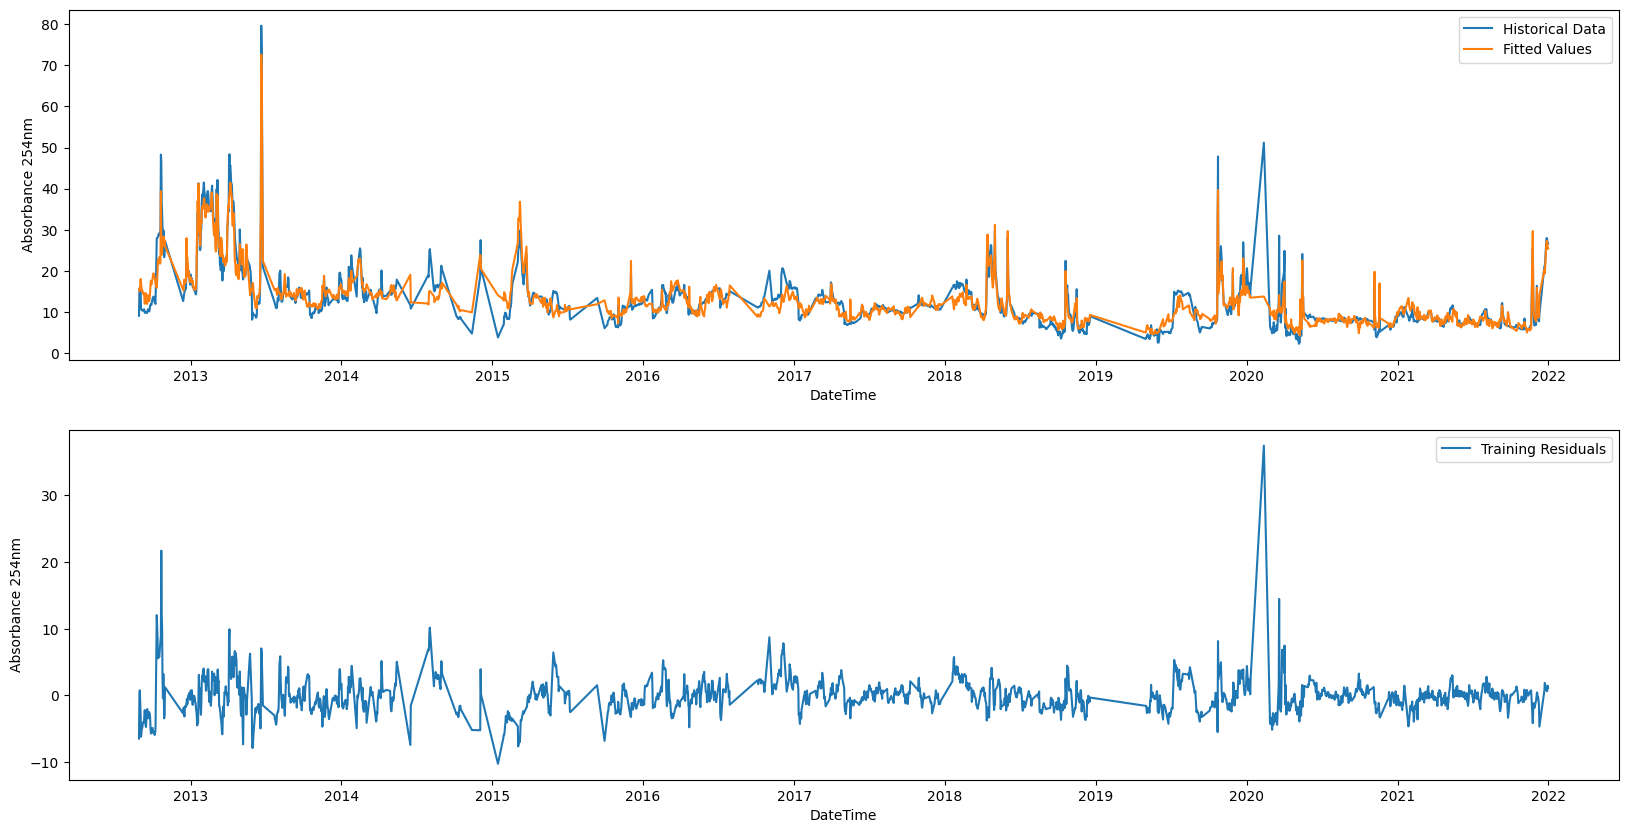

In [95]:
# plot the time series of the residuals and of the train set
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
sns.lineplot(x=y_train['DateTime'], y=y_train['Absorbance 254nm'], label='Historical Data', ax=ax[0])
sns.lineplot(x=y_train['DateTime'], y=train_predictions, label='Fitted Values', ax=ax[0])   

sns.lineplot(x=y_train['DateTime'], y=train_residuals, label='Training Residuals' , ax=ax[1])

plt.show()

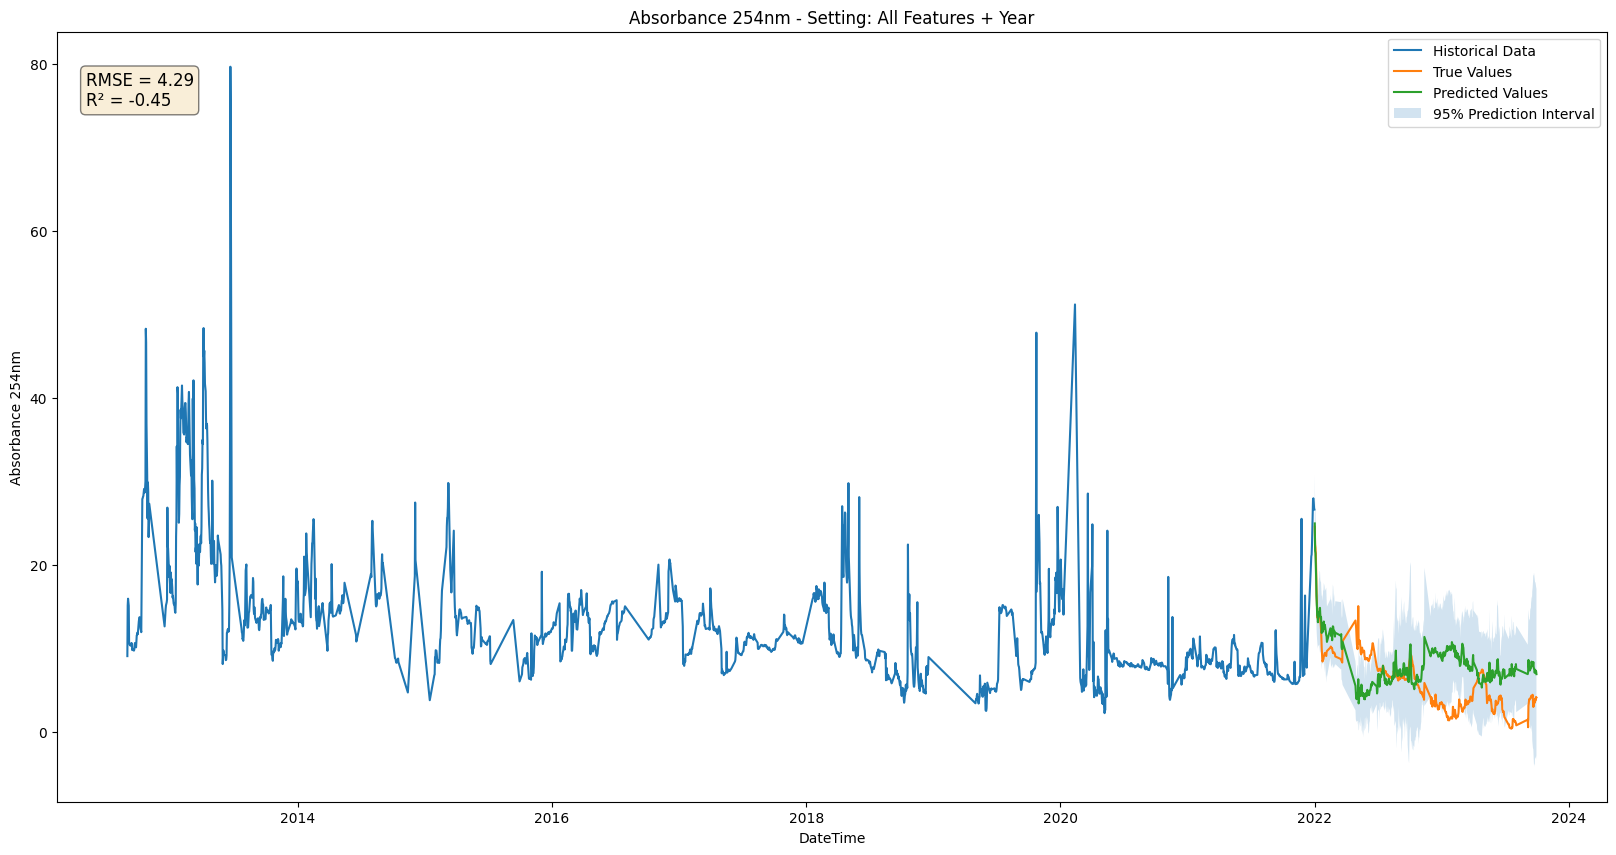

In [96]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=y_train['DateTime'], y=y_train['Absorbance 254nm'], label='Historical Data')
sns.lineplot(x=y_test['DateTime'], y=y_test['Absorbance 254nm'], label='True Values')
sns.lineplot(x=y_test['DateTime'], y=y_pred, label='Predicted Values')
plt.fill_between(y_test['DateTime'], lower_bound, upper_bound, alpha=0.2, label='95% Prediction Interval')
plt.xlabel('DateTime')
plt.ylabel('Absorbance 254nm')

# add rmse and r2 to the plot in a box
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

text_string = '\n'.join((
    f'RMSE = {rmse:.2f}',
    f'R\u00b2 = {r2:.2f}',
))

plt.text(y_train['DateTime'].iloc[0] - pd.Timedelta(days=120), 75, s=text_string, fontsize=12, bbox=props)

plt.title(f'Absorbance 254nm - Setting: {setting}')

plt.legend()
plt.show()

## Store Results

In [97]:
nn_pred = y_pred
nn_lower_bound = lower_bound
nn_upper_bound = upper_bound
nn_rmse = rmse
nn_r2 = r2

# Final Plot

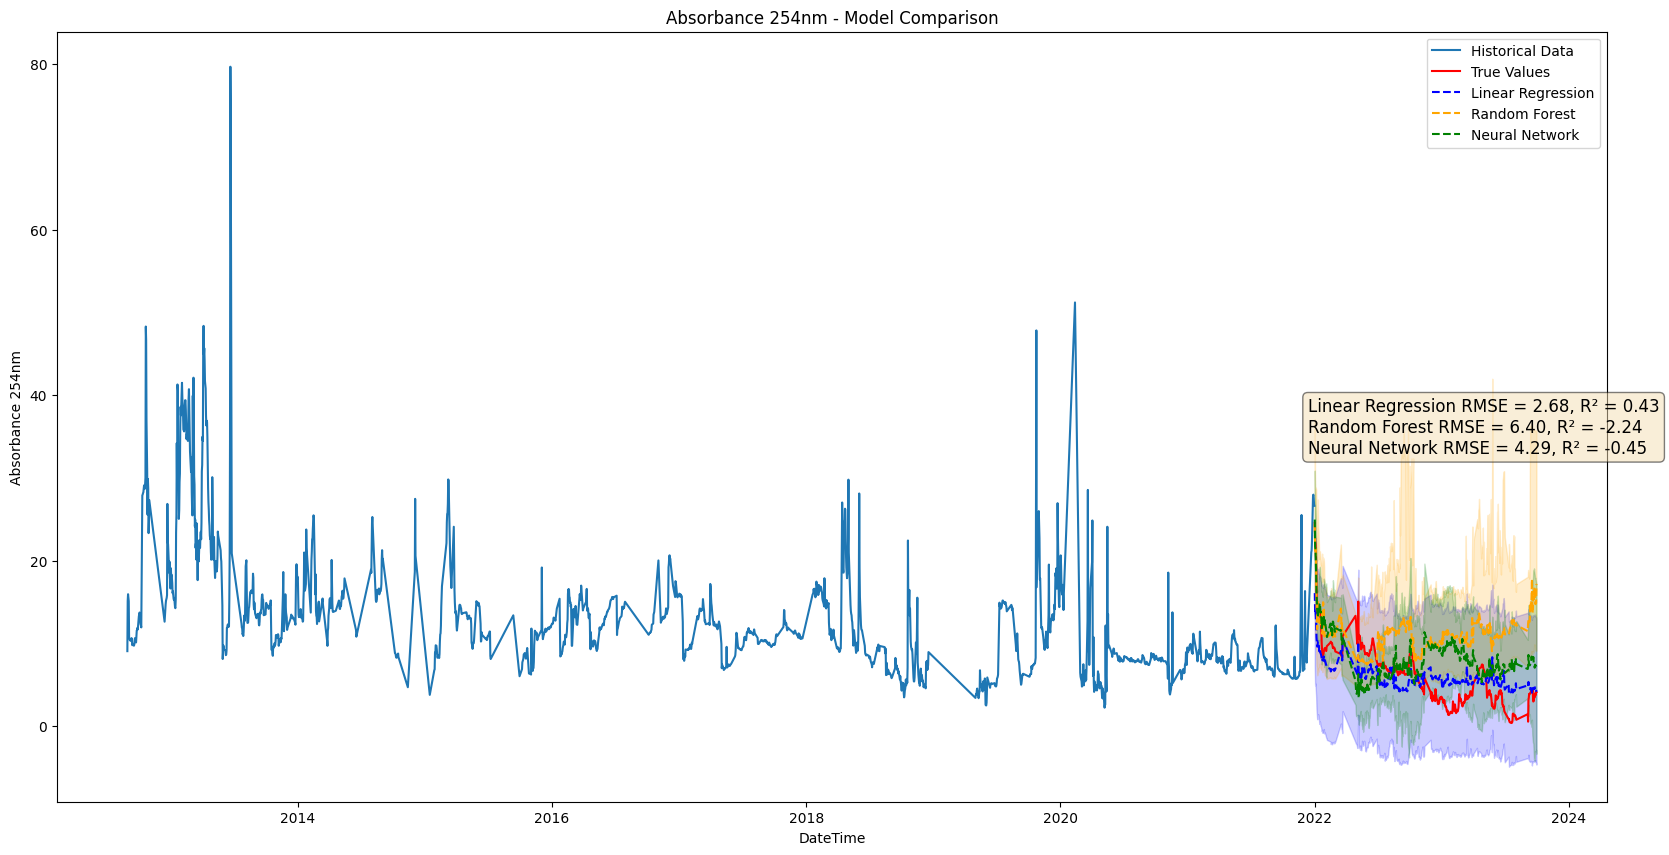

In [101]:
# create a plot for the comparison of the models
plt.figure(figsize=(20, 10))
sns.lineplot(x=y_train['DateTime'], y=y_train['Absorbance 254nm'], label='Historical Data')
sns.lineplot(x=y_test['DateTime'], y=y_test['Absorbance 254nm'], label='True Values', color='red')

# Linear Regression
sns.lineplot(x=y_test['DateTime'], y=lr_pred, label='Linear Regression', linestyle='--', color='blue')
plt.fill_between(y_test['DateTime'], lr_lower_bound, lr_upper_bound, alpha=0.2, color='blue')

# Random Forest
sns.lineplot(x=y_test['DateTime'], y=rf_pred, label='Random Forest', linestyle='--', color='orange')
plt.fill_between(y_test['DateTime'], rf_lower_bound, rf_upper_bound, alpha=0.2, color='orange')

# Neural Network
sns.lineplot(x=y_test['DateTime'], y=nn_pred, label='Neural Network', linestyle='--', color='green')
plt.fill_between(y_test['DateTime'], nn_lower_bound, nn_upper_bound, alpha=0.2, color='green')

plt.xlabel('DateTime')
plt.ylabel('Absorbance 254nm')

# add rmse and r2 to the plot in a box
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

text_string = '\n'.join((
    f'Linear Regression RMSE = {lr_rmse:.2f}, R\u00b2 = {lr_r2:.2f}',
    f'Random Forest RMSE = {rf_rmse:.2f}, R\u00b2 = {rf_r2:.2f}',
    f'Neural Network RMSE = {nn_rmse:.2f}, R\u00b2 = {nn_r2:.2f}',
))

plt.text(y_test['DateTime'].iloc[0] - pd.Timedelta(days=20), 33, s=text_string, fontsize=12, bbox=props)

plt.title(f'Absorbance 254nm - Model Comparison')

plt.legend()
plt.show()

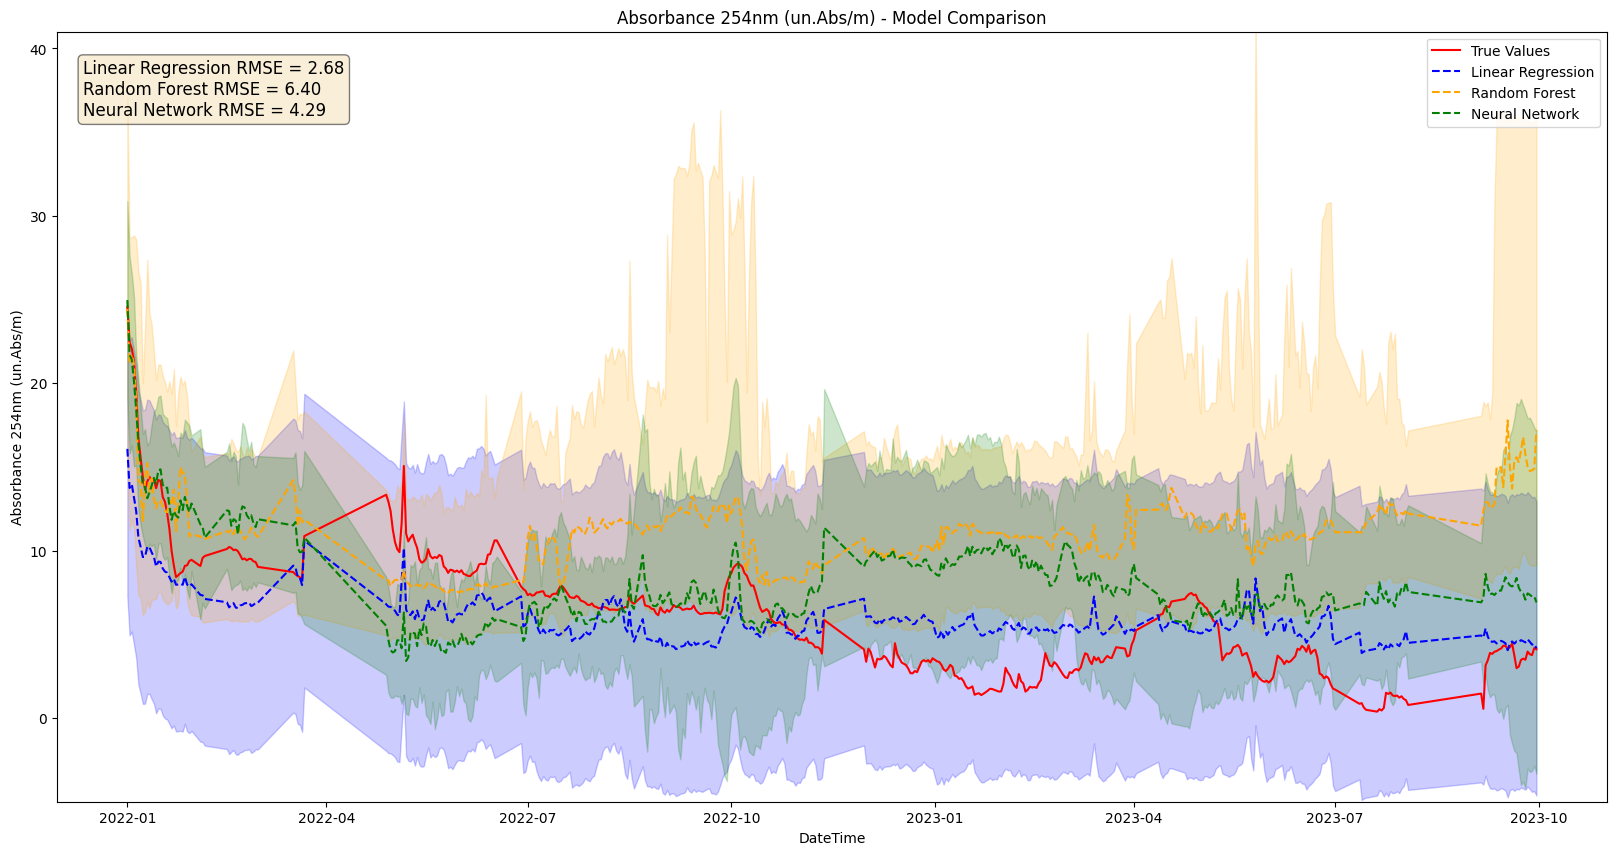

In [115]:
# create a plot for the comparison of the models
plt.figure(figsize=(20, 10))
# sns.lineplot(x=y_train['DateTime'], y=y_train['Absorbance 254nm'], label='Historical Data')
sns.lineplot(x=y_test['DateTime'], y=y_test['Absorbance 254nm'], label='True Values', color='red')

# Linear Regression
sns.lineplot(x=y_test['DateTime'], y=lr_pred, label='Linear Regression', linestyle='--', color='blue')
plt.fill_between(y_test['DateTime'], lr_lower_bound, lr_upper_bound, alpha=0.2, color='blue')

# Random Forest
sns.lineplot(x=y_test['DateTime'], y=rf_pred, label='Random Forest', linestyle='--', color='orange')
plt.fill_between(y_test['DateTime'], rf_lower_bound, rf_upper_bound, alpha=0.2, color='orange')

# Neural Network
sns.lineplot(x=y_test['DateTime'], y=nn_pred, label='Neural Network', linestyle='--', color='green')
plt.fill_between(y_test['DateTime'], nn_lower_bound, nn_upper_bound, alpha=0.2, color='green')

#change the y range to see the differences  
plt.ylim(-5, 41)

plt.xlabel('DateTime')
plt.ylabel('Absorbance 254nm (un.Abs/m)')

# add rmse and r2 to the plot in a box
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

text_string = '\n'.join((
    f'Linear Regression RMSE = {lr_rmse:.2f}',
    f'Random Forest RMSE = {rf_rmse:.2f}',
    f'Neural Network RMSE = {nn_rmse:.2f}',
))

plt.text(y_test['DateTime'].iloc[0] - pd.Timedelta(days=20), 36, s=text_string, fontsize=12, bbox=props)

plt.title(f'Absorbance 254nm (un.Abs/m) - Model Comparison')

plt.legend()
plt.show()